# Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import yfinance as yf
from scipy.optimize import linprog, minimize, Bounds
from scipy.linalg import cholesky, LinAlgError
from scipy import stats
from sklearn.covariance import LedoitWolf, OAS, GraphicalLassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Get historical stock history


In [2]:
# Define the ticker symbols for the stocks
tickers = ['XRO.AX', 'TNE.AX', 'BHP.AX', 'NST.AX', 'CSL.AX','PME.AX', 'CBA.AX', 'NAB.AX', 'WDS.AX', 'STO.AX'] 
# Set the time period for data download - 5 years from now
import datetime as dt
end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (dt.datetime.now() - dt.timedelta(days=5*365)).strftime('%Y-%m-%d')

# Download the adjusted close prices for all tickers
stock_data = yf.download(tickers, start=start_date, end=end_date, auto_adjust=False)['Adj Close']

# Display the first few rows of the data
print("Downloaded stock data:")
print(stock_data.head())
print(stock_data.tail())





[*********************100%***********************]  10 of 10 completed

Downloaded stock data:
Ticker         BHP.AX     CBA.AX      CSL.AX     NAB.AX     NST.AX     PME.AX  \
Date                                                                            
2020-10-15  22.691902  57.517220  281.284821  15.160648  14.165229  30.707928   
2020-10-16  22.370995  57.484005  279.425110  15.152763  14.094668  29.518156   
2020-10-19  22.525276  58.123272  284.219269  15.294675  14.332814  31.484722   
2020-10-20  22.154999  57.400990  281.331604  15.129114  14.297531  32.035362   
2020-10-21  22.284594  57.841003  277.668182  15.373514  14.279895  32.733490   

Ticker        STO.AX    TNE.AX     WDS.AX      XRO.AX  
Date                                                   
2020-10-15  4.216200  7.992885  13.013932  115.500000  
2020-10-16  4.127693  7.917482  12.922730  114.550003  
2020-10-19  4.151831  8.143697  13.013932  116.449997  
2020-10-20  4.087462  8.219100  12.824512  117.050003  
2020-10-21  4.167923  8.341634  13.027965  116.760002  
Ticker         BH

In [3]:
# Set the date column as the index and ensure it's in datetime format
stock_data.index = pd.to_datetime(stock_data.index)



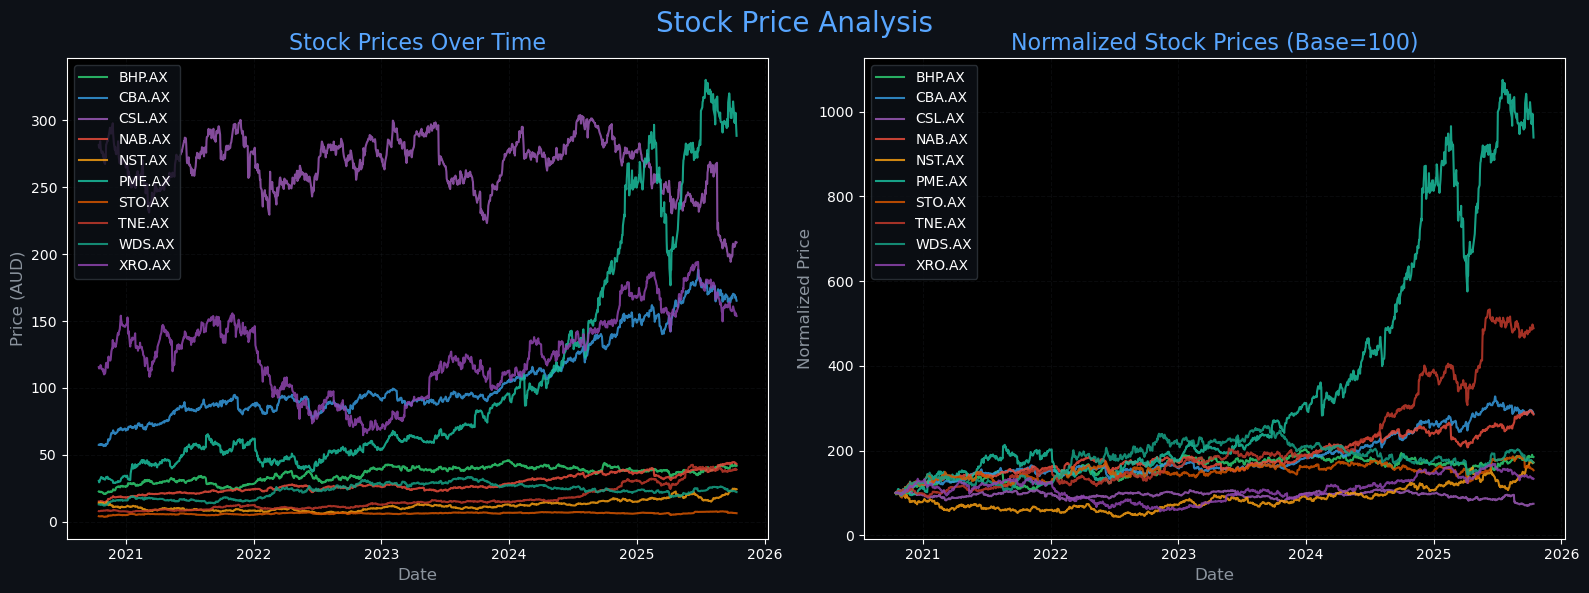

In [4]:
# Visualize the stock prices over time
plt.style.use('dark_background')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Stock Price Analysis', fontsize=20, color='#58a6ff', y=0.98)

# Define a modern color palette
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', 
          '#1abc9c', '#d35400', '#c0392b', '#16a085', '#8e44ad']

# Plot 1: Raw stock prices
for i, ticker in enumerate(stock_data.columns):
    ax1.plot(stock_data.index, stock_data[ticker], linewidth=1.5, alpha=0.85, 
             label=ticker, color=colors[i % len(colors)])

ax1.set_title('Stock Prices Over Time', fontsize=16, color='#58a6ff')
ax1.set_xlabel('Date', fontsize=12, color='#8b949e')
ax1.set_ylabel('Price (AUD)', fontsize=12, color='#8b949e')
ax1.grid(True, linestyle='--', alpha=0.2, color='#30363d')
ax1.legend(loc='upper left', frameon=True, facecolor='#0d1117', edgecolor='#30363d', fontsize=10)

# Plot 2: Normalized stock prices (starting at 100)
normalized_data = stock_data / stock_data.iloc[0] * 100

for i, ticker in enumerate(normalized_data.columns):
    ax2.plot(normalized_data.index, normalized_data[ticker], linewidth=1.5, alpha=0.85, 
             label=ticker, color=colors[i % len(colors)])

ax2.set_title('Normalized Stock Prices (Base=100)', fontsize=16, color='#58a6ff')
ax2.set_xlabel('Date', fontsize=12, color='#8b949e')
ax2.set_ylabel('Normalized Price', fontsize=12, color='#8b949e')
ax2.grid(True, linestyle='--', alpha=0.2, color='#30363d')
ax2.legend(loc='upper left', frameon=True, facecolor='#0d1117', edgecolor='#30363d', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


# Calculate the log return

In [5]:
# Calculate the log returns for each stock
log_returns = np.log(stock_data / stock_data.shift(1))

# Drop the first row which contains NaN values due to the shift operation
log_returns = log_returns.dropna()

# Display the first few rows of log returns
print("Log returns:")
print(log_returns.head())

# Calculate summary statistics for the log returns
print("\nSummary statistics of log returns:")
print(log_returns.describe())




Log returns:
Ticker        BHP.AX    CBA.AX    CSL.AX    NAB.AX    NST.AX    PME.AX  \
Date                                                                     
2020-10-16 -0.014243 -0.000578 -0.006633 -0.000520 -0.004994 -0.039515   
2020-10-19  0.006873  0.011059  0.017012  0.009322  0.016755  0.064497   
2020-10-20 -0.016575 -0.012505 -0.010212 -0.010884 -0.002465  0.017338   
2020-10-21  0.005832  0.007636 -0.013107  0.016025 -0.001234  0.021558   
2020-10-22  0.010194 -0.004892 -0.002628 -0.004626  0.000617  0.024627   

Ticker        STO.AX    TNE.AX    WDS.AX    XRO.AX  
Date                                                
2020-10-16 -0.021216 -0.009479 -0.007033 -0.008259  
2020-10-19  0.005831  0.028171  0.007033  0.016451  
2020-10-20 -0.015625  0.009216 -0.014662  0.005139  
2020-10-21  0.019494  0.014798  0.015740 -0.002481  
2020-10-22 -0.019494  0.001129 -0.016287 -0.012236  

Summary statistics of log returns:
Ticker       BHP.AX       CBA.AX       CSL.AX       NAB.AX   

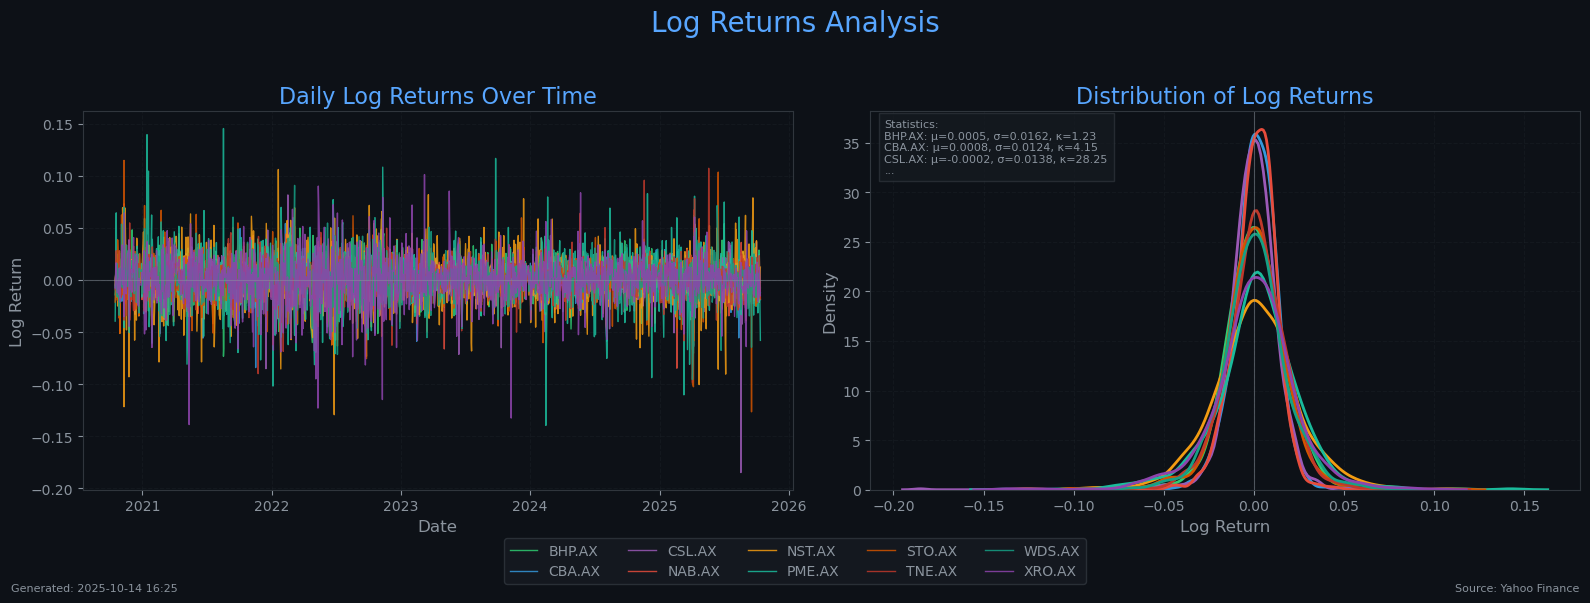

In [6]:
# Visualize the log returns with a professional
plt.style.use('dark_background')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.patch.set_facecolor('#0d1117')
fig.suptitle('Log Returns Analysis', fontsize=20, color='#58a6ff', y=0.98)

# Define a modern color palette
colors = ['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12', 
          '#1abc9c', '#d35400', '#c0392b', '#16a085', '#8e44ad']

# Plot 1: Time series of log returns for each stock
for i, column in enumerate(log_returns.columns):
    ax1.plot(log_returns.index, log_returns[column], linewidth=1.0, alpha=0.85, 
             label=column, color=colors[i % len(colors)])

ax1.set_title('Daily Log Returns Over Time', fontsize=16, color='#58a6ff')
ax1.set_xlabel('Date', fontsize=12, color='#8b949e')
ax1.set_ylabel('Log Return', fontsize=12, color='#8b949e')
ax1.grid(True, linestyle='--', alpha=0.2, color='#30363d')
ax1.tick_params(axis='both', labelsize=10, colors='#8b949e')
ax1.set_facecolor('#0d1117')
for spine in ax1.spines.values():
    spine.set_color('#30363d')

# Add horizontal line at y=0
ax1.axhline(y=0, color='#8b949e', linestyle='-', linewidth=0.8, alpha=0.5)

# Plot 2: Distribution of log returns with kernel density estimation
for i, column in enumerate(log_returns.columns):
    sns.kdeplot(log_returns[column], ax=ax2, label=column, 
                color=colors[i % len(colors)], linewidth=2)

ax2.set_title('Distribution of Log Returns', fontsize=16, color='#58a6ff')
ax2.set_xlabel('Log Return', fontsize=12, color='#8b949e')
ax2.set_ylabel('Density', fontsize=12, color='#8b949e')
ax2.grid(True, linestyle='--', alpha=0.2, color='#30363d')
ax2.tick_params(axis='both', labelsize=10, colors='#8b949e')
ax2.set_facecolor('#0d1117')
for spine in ax2.spines.values():
    spine.set_color('#30363d')

# Add vertical line at x=0 for reference
ax2.axvline(x=0, color='#8b949e', linestyle='-', linewidth=0.8, alpha=0.5)

# Add statistical annotations to the second plot
mean_returns = log_returns.mean()
std_returns = log_returns.std()
kurtosis_values = log_returns.kurtosis()

stats_text = "Statistics:\n"
for i, col in enumerate(log_returns.columns[:3]):  # Show stats for first 3 stocks only
    stats_text += f"{col}: μ={mean_returns[col]:.4f}, σ={std_returns[col]:.4f}, κ={kurtosis_values[col]:.2f}\n"
stats_text += "..."

ax2.text(0.02, 0.98, stats_text, transform=ax2.transAxes, 
         fontsize=8, color='#8b949e', va='top', 
         bbox=dict(facecolor='#161b22', alpha=0.7, edgecolor='#30363d'))

# Create a single legend for both plots at the bottom of the figure
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01), 
           ncol=5, fontsize=10, facecolor='#161b22', edgecolor='#30363d', 
           labelcolor='#8b949e')

# Add timestamp and data source info
plt.figtext(0.01, 0.01, f"Generated: {dt.datetime.now().strftime('%Y-%m-%d %H:%M')}", 
            fontsize=8, color='#8b949e')
plt.figtext(0.99, 0.01, "Source: Yahoo Finance", fontsize=8, color='#8b949e', 
            ha='right')

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()


#  Exploratory Data Analysis (EDA)

## Mean return 

In [7]:
# Calculate annualized mean return (expected return)
# Assuming 252 trading days in a year
annualized_mean_return = log_returns.mean() * 252
print("\nAnnualized Mean Return (Expected Return):")
print(annualized_mean_return)


Annualized Mean Return (Expected Return):
Ticker
BHP.AX    0.122413
CBA.AX    0.210668
CSL.AX   -0.059552
NAB.AX    0.209142
NST.AX    0.108177
PME.AX    0.447207
STO.AX    0.085513
TNE.AX    0.316755
WDS.AX    0.107274
XRO.AX    0.057199
dtype: float64


## Volatility (Risk)

In [8]:
# Calculate annualized volatility (risk)
annualized_volatility = log_returns.std() * np.sqrt(252)
print("\nAnnualized Volatility (Risk):")
print(annualized_volatility)



Annualized Volatility (Risk):
Ticker
BHP.AX    0.257382
CBA.AX    0.196449
CSL.AX    0.219403
NAB.AX    0.193077
NST.AX    0.380378
PME.AX    0.386489
STO.AX    0.292313
TNE.AX    0.274951
WDS.AX    0.288513
XRO.AX    0.365690
dtype: float64



Risk-Return Profile:
        Expected Return  Risk (Volatility)
Ticker                                    
BHP.AX         0.122413           0.257382
CBA.AX         0.210668           0.196449
CSL.AX        -0.059552           0.219403
NAB.AX         0.209142           0.193077
NST.AX         0.108177           0.380378
PME.AX         0.447207           0.386489
STO.AX         0.085513           0.292313
TNE.AX         0.316755           0.274951
WDS.AX         0.107274           0.288513
XRO.AX         0.057199           0.365690


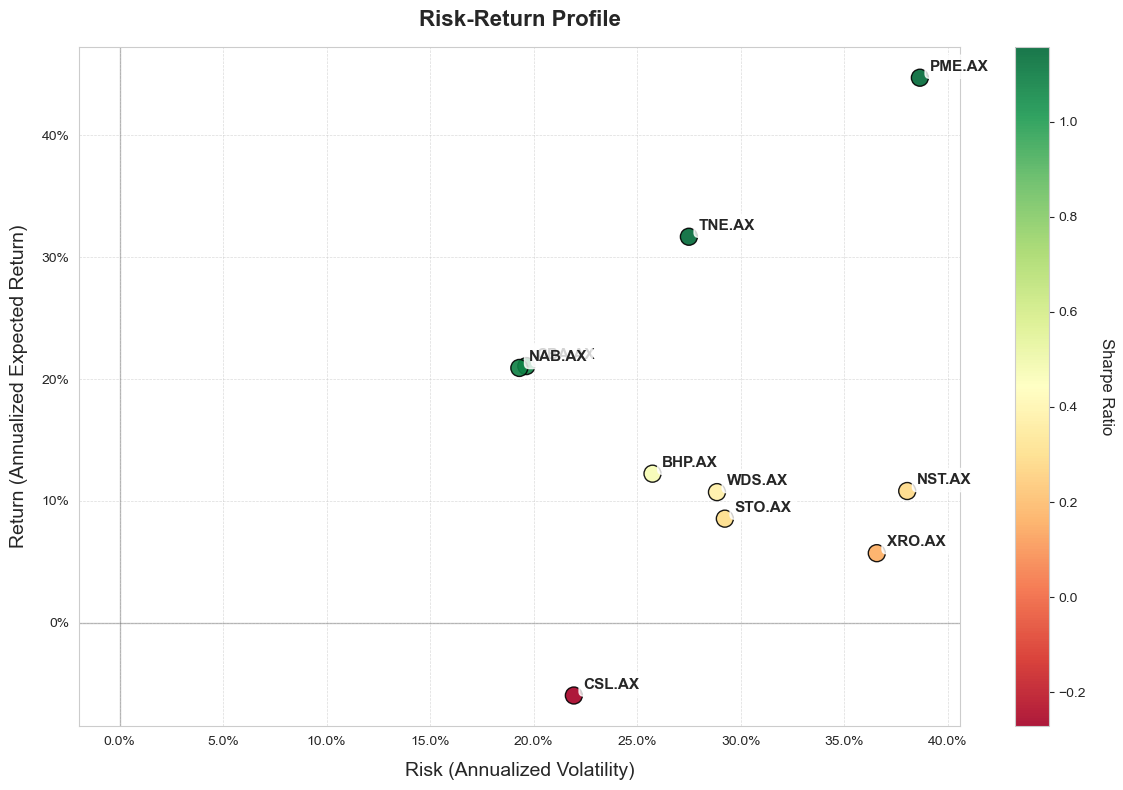

In [9]:

# Create a DataFrame to display both metrics side by side
risk_return_profile = pd.DataFrame({
    'Expected Return': annualized_mean_return,
    'Risk (Volatility)': annualized_volatility
})

print("\nRisk-Return Profile:")
print(risk_return_profile)

# Create a professional financial visualization of the risk-return profile
plt.figure(figsize=(12, 8), facecolor='white')
sns.set_style("whitegrid")

# Create a scatter plot with professional styling
scatter = plt.scatter(
    annualized_volatility, 
    annualized_mean_return, 
    s=150, 
    c=annualized_mean_return/annualized_volatility,  # Color by Sharpe ratio
    cmap='RdYlGn',  # Red to Green color scheme
    alpha=0.9,
    edgecolors='black',
    linewidths=1
)

# Add labels for each stock
for i, stock in enumerate(annualized_volatility.index):
    plt.annotate(
        stock, 
        (annualized_volatility.iloc[i], annualized_mean_return.iloc[i]),
        xytext=(7, 5),
        textcoords='offset points',
        fontsize=11,
        fontweight='bold',
        bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.8)
    )

# Add reference lines
plt.axhline(y=0, color='dimgray', linestyle='-', alpha=0.4, linewidth=1)
plt.axvline(x=0, color='dimgray', linestyle='-', alpha=0.4, linewidth=1)

# Add a colorbar to indicate Sharpe ratio
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio', rotation=270, labelpad=20, fontsize=12)

# Add titles and labels
plt.title('Risk-Return Profile', fontsize=16, fontweight='bold', pad=15)
plt.xlabel('Risk (Annualized Volatility)', fontsize=14, labelpad=10)
plt.ylabel('Return (Annualized Expected Return)', fontsize=14, labelpad=10)

# Format axis ticks as percentages
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))

# Add grid for better readability
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()


## Covariance matrix

Ticker    BHP.AX    CBA.AX    CSL.AX    NAB.AX    NST.AX    PME.AX    STO.AX  \
Ticker                                                                         
BHP.AX  0.066245  0.009912  0.002546  0.010229  0.021465  0.005343  0.032402   
CBA.AX  0.009912  0.038592  0.011570  0.027888  0.006696  0.017944  0.015047   
CSL.AX  0.002546  0.011570  0.048138  0.009526  0.004651  0.024199  0.004412   
NAB.AX  0.010229  0.027888  0.009526  0.037279  0.000239  0.014120  0.016196   
NST.AX  0.021465  0.006696  0.004651  0.000239  0.144687  0.013386  0.006415   
PME.AX  0.005343  0.017944  0.024199  0.014120  0.013386  0.149374  0.004402   
STO.AX  0.032402  0.015047  0.004412  0.016196  0.006415  0.004402  0.085447   
TNE.AX  0.007752  0.014811  0.016620  0.014867  0.012789  0.046852  0.006929   
WDS.AX  0.033011  0.012643  0.003775  0.013309  0.009661  0.000971  0.067109   
XRO.AX  0.008143  0.020310  0.022966  0.018859  0.018235  0.064621  0.007006   

Ticker    TNE.AX    WDS.AX    XRO.AX  


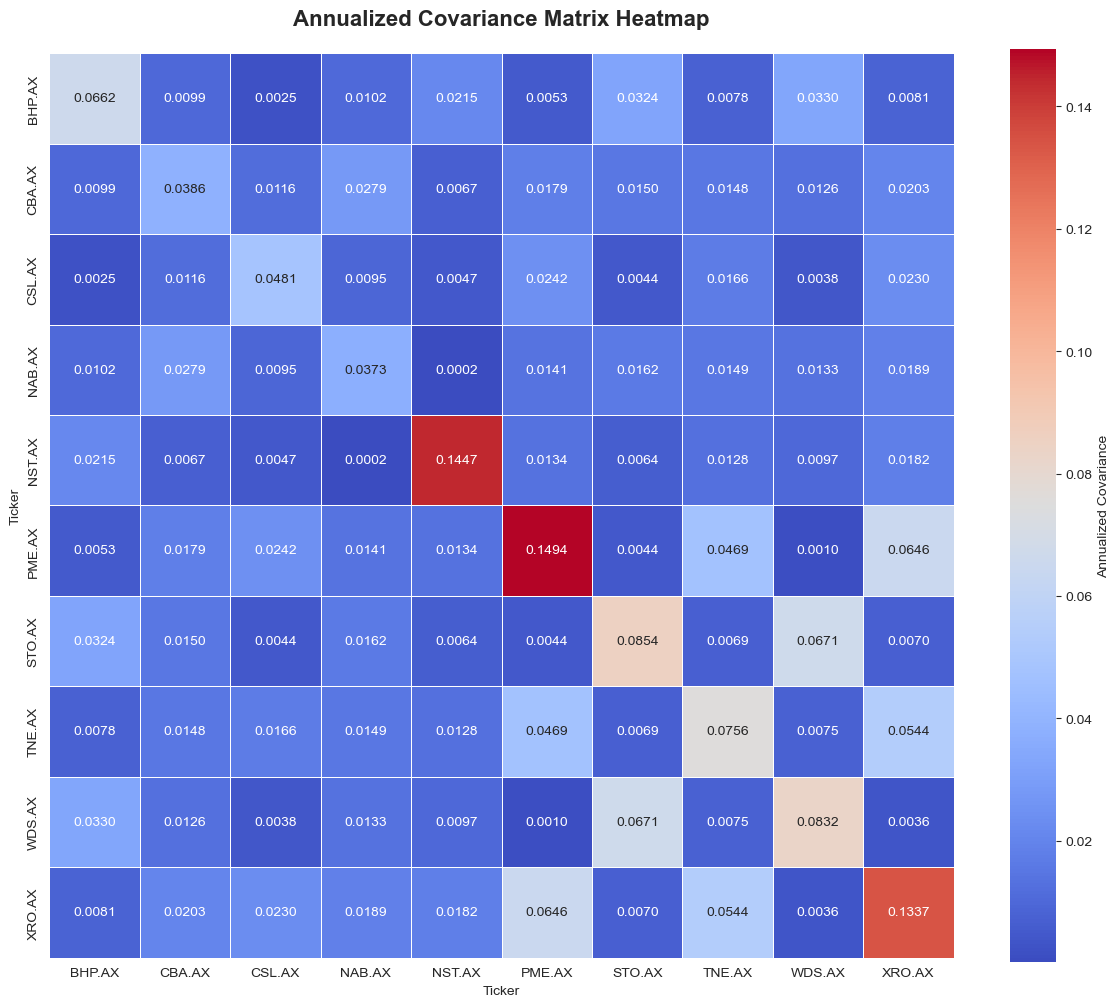

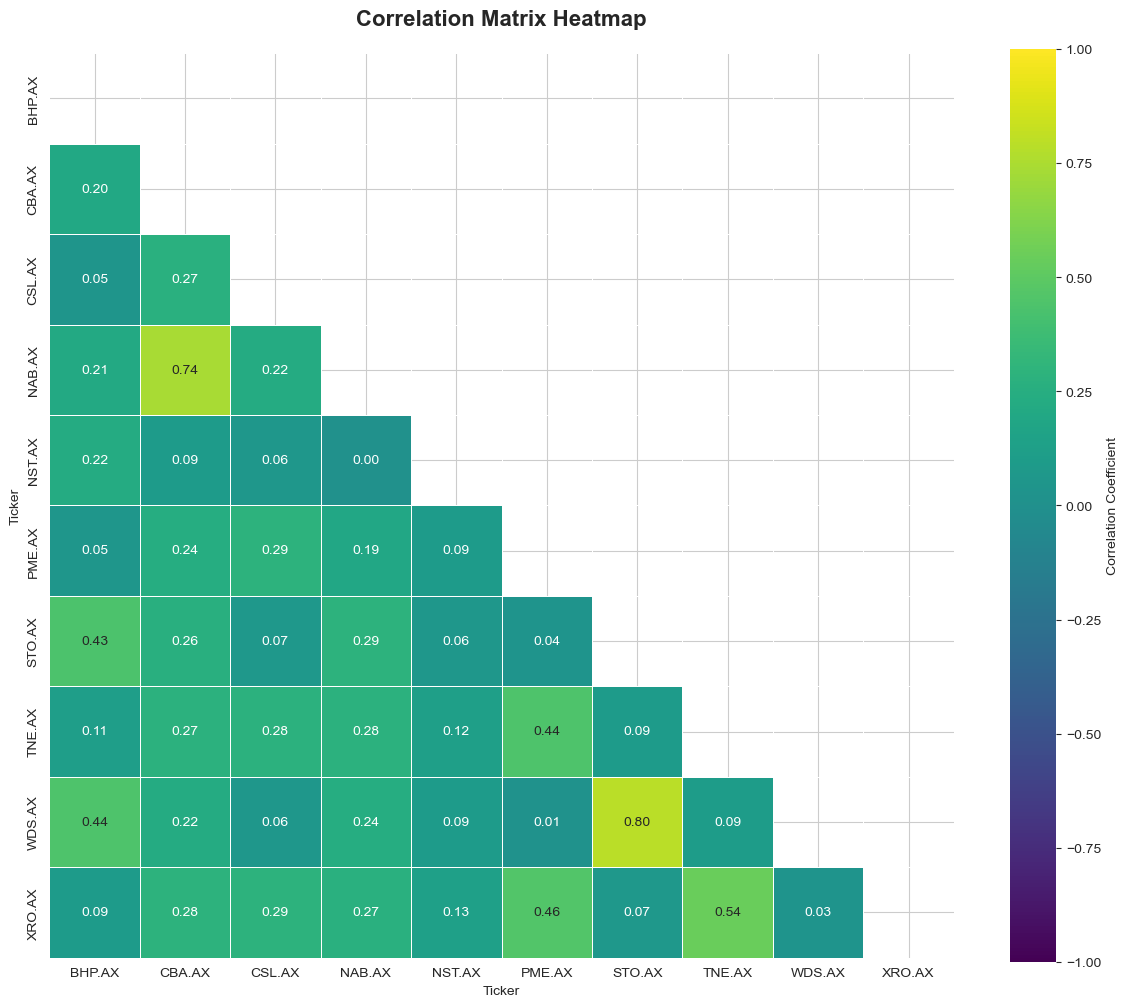

In [10]:
annualized_cov_matrix = log_returns.cov()*252

print(annualized_cov_matrix)

# Visualize the covariance matrix as a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    annualized_cov_matrix, 
    annot=True, 
    cmap='coolwarm', 
    fmt='.4f',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Annualized Covariance'}
)
plt.title('Annualized Covariance Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Visualize correlation matrix
correlation_matrix = log_returns.corr()
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(
    correlation_matrix,
    annot=True,
    mask=mask,
    cmap='viridis',
    vmin=-1, vmax=1,
    fmt='.2f',
    linewidths=0.5,
    square=True,
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



# Calculate the performance metrics


## Sharp ratio



                        SHARPE RATIO ANALYSIS                         
Ticker             Sharpe Ratio        Performance Rating
PME.AX                   1.1054                 Very Good
TNE.AX                   1.0793                 Very Good
NAB.AX                   0.9796                      Good
CBA.AX                   0.9706                      Good
BHP.AX                   0.3979                Acceptable
WDS.AX                   0.3025                Acceptable
NST.AX                   0.2318                Acceptable
STO.AX                   0.2241                Acceptable
XRO.AX                   0.1017                Acceptable
CSL.AX                  -0.3626                      Poor

Risk-Free Rate: 2.00%
Analysis Period: 2020-10-16 to 2025-10-13




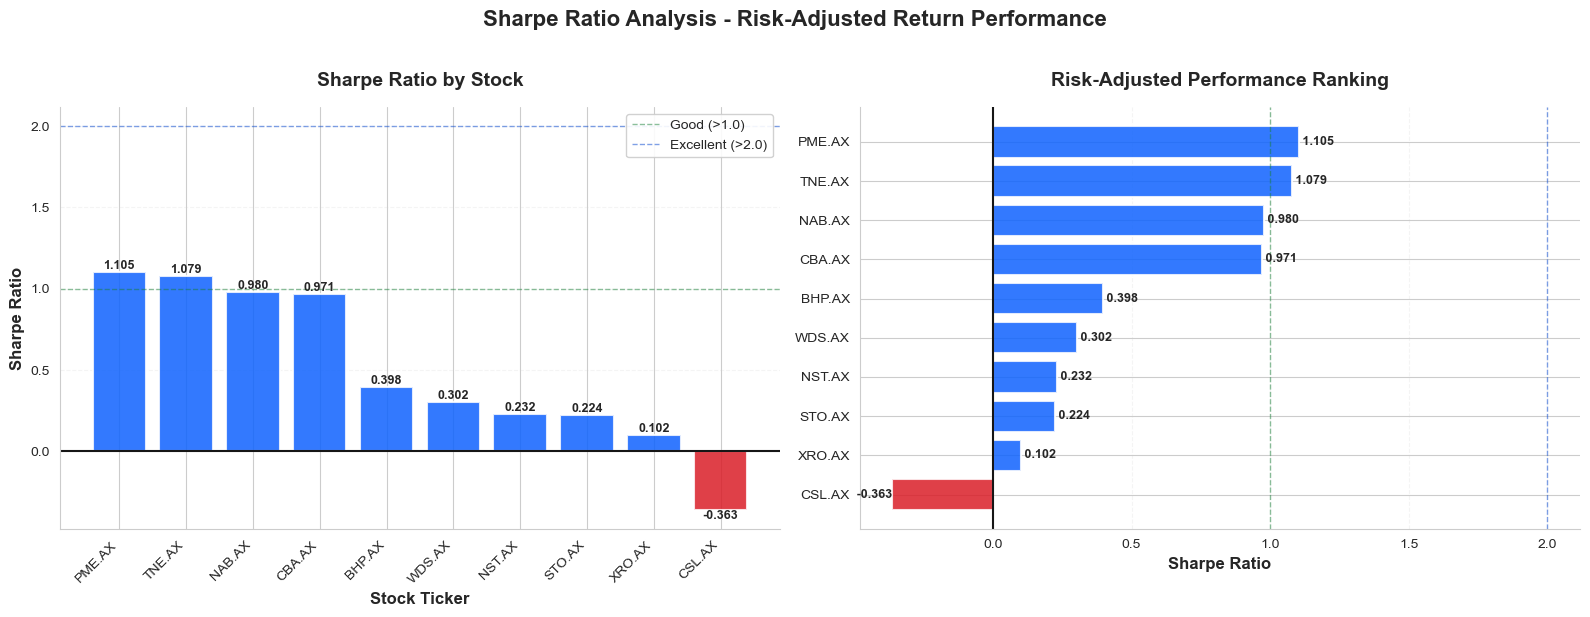

In [11]:
# Calculate Sharpe Ratio for each stock
risk_free_rate = 0.02  # Assuming 2% annual risk-free rate


# Calculate Sharpe Ratio
sharpe_ratios = (annualized_mean_return - risk_free_rate) / annualized_volatility

# Display results in a professional format
print("SHARPE RATIO ANALYSIS".center(70))
print(f"{'Ticker':<15} {'Sharpe Ratio':>15} {'Performance Rating':>25}")


# Define performance rating based on Sharpe Ratio
def get_performance_rating(sharpe):
    if sharpe > 2:
        return "Excellent"
    elif sharpe > 1:
        return "Very Good"
    elif sharpe > 0.5:
        return "Good"
    elif sharpe > 0:
        return "Acceptable"
    else:
        return "Poor"

for ticker, sharpe in sharpe_ratios.sort_values(ascending=False).items():
    rating = get_performance_rating(sharpe)
    print(f"{ticker:<15} {sharpe:>15.4f} {rating:>25}")


print(f"\nRisk-Free Rate: {risk_free_rate:.2%}")
print(f"Analysis Period: {log_returns.index[0].strftime('%Y-%m-%d')} to {log_returns.index[-1].strftime('%Y-%m-%d')}")
print("\n")

# Create professional visualization with IBM-style aesthetics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: Bar chart with enhanced styling
sorted_sharpe = sharpe_ratios.sort_values(ascending=False)
colors = ['#0f62fe' if x > 0 else '#da1e28' for x in sorted_sharpe.values]
bars = ax1.bar(range(len(sorted_sharpe)), sorted_sharpe.values, color=colors, 
               edgecolor='white', linewidth=1.5, alpha=0.85)

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, sorted_sharpe.values)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}',
             ha='center', va='bottom' if height > 0 else 'top',
             fontsize=9, fontweight='bold')

ax1.set_xticks(range(len(sorted_sharpe)))
ax1.set_xticklabels(sorted_sharpe.index, rotation=45, ha='right')
ax1.axhline(y=0, color='#161616', linestyle='-', linewidth=1.5)
ax1.axhline(y=1, color='#198038', linestyle='--', linewidth=1, alpha=0.5, label='Good (>1.0)')
ax1.axhline(y=2, color='#0043ce', linestyle='--', linewidth=1, alpha=0.5, label='Excellent (>2.0)')
ax1.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax1.set_xlabel('Stock Ticker', fontsize=12, fontweight='bold')
ax1.set_title('Sharpe Ratio by Stock', fontsize=14, fontweight='bold', pad=15)
ax1.grid(axis='y', alpha=0.2, linestyle='--')
ax1.legend(loc='upper right', framealpha=0.9)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Right plot: Horizontal bar chart for comparison
sorted_sharpe_asc = sharpe_ratios.sort_values(ascending=True)
colors_h = ['#0f62fe' if x > 0 else '#da1e28' for x in sorted_sharpe_asc.values]
bars_h = ax2.barh(range(len(sorted_sharpe_asc)), sorted_sharpe_asc.values, 
                   color=colors_h, edgecolor='white', linewidth=1.5, alpha=0.85)

# Add value labels
for i, (bar, value) in enumerate(zip(bars_h, sorted_sharpe_asc.values)):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f' {value:.3f}',
             ha='left' if width > 0 else 'right',
             va='center', fontsize=9, fontweight='bold')

ax2.set_yticks(range(len(sorted_sharpe_asc)))
ax2.set_yticklabels(sorted_sharpe_asc.index)
ax2.axvline(x=0, color='#161616', linestyle='-', linewidth=1.5)
ax2.axvline(x=1, color='#198038', linestyle='--', linewidth=1, alpha=0.5)
ax2.axvline(x=2, color='#0043ce', linestyle='--', linewidth=1, alpha=0.5)
ax2.set_xlabel('Sharpe Ratio', fontsize=12, fontweight='bold')
ax2.set_title('Risk-Adjusted Performance Ranking', fontsize=14, fontweight='bold', pad=15)
ax2.grid(axis='x', alpha=0.2, linestyle='--')
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.suptitle('Sharpe Ratio Analysis - Risk-Adjusted Return Performance', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


# Portfolio Optimizaion 

## Mean-Variance Portfolio Optimization (MVO) 

Portfolio Optimization Process - Quantitative Trading Approach
Expected Annual Returns:
Ticker
PME.AX    0.447207
TNE.AX    0.316755
CBA.AX    0.210668
dtype: float64

Risk-free rate: 2.00%
Target return: 30.00%

--- Optimized Portfolios ---
Maximum Sharpe Ratio Portfolio (Market Portfolio):
Expected Return: 27.99%
Expected Volatility: 17.71%
Sharpe Ratio: 1.4670

Minimum Volatility Portfolio:
Expected Return: 12.19%
Expected Volatility: 13.59%
Sharpe Ratio: 0.7498

Target Return Portfolio (30.00%):
Expected Volatility: 19.21%
Sharpe Ratio: 1.4578

--- Maximum Sharpe Portfolio Allocation ---
        weight
Ticker        
NAB.AX   28.00
TNE.AX   23.87
PME.AX   21.87
CBA.AX   18.10
BHP.AX    6.50
NST.AX    1.36


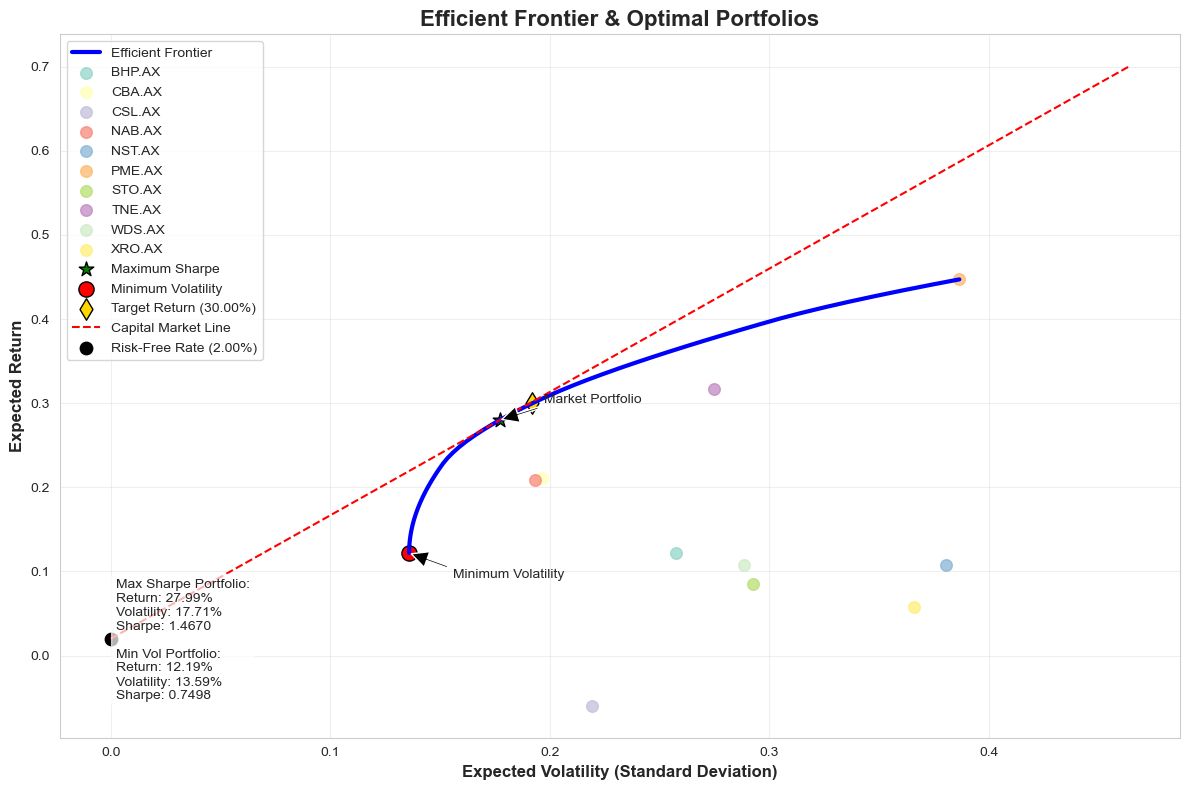

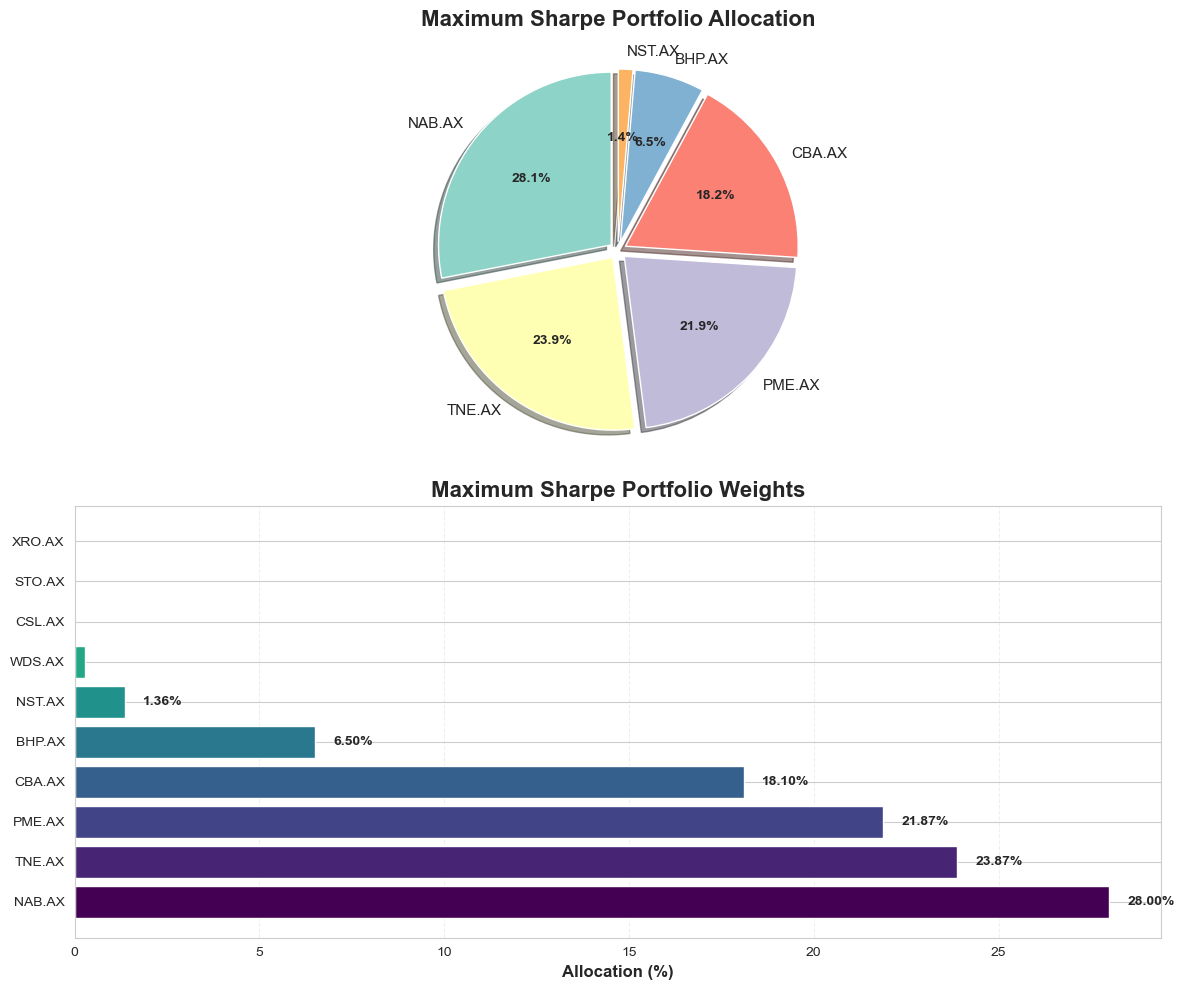


--- Risk Contribution Analysis ---
Percentage of portfolio risk contributed by each asset:
Ticker
PME.AX    35.96
TNE.AX    27.26
NAB.AX    20.37
CBA.AX    13.28
BHP.AX     2.56
NST.AX     0.46
WDS.AX     0.10
STO.AX     0.00
CSL.AX     0.00
XRO.AX     0.00
Name: risk_contrib_pct, dtype: float64


In [12]:
# Mean-Variance Portfolio Optimization - Realistic Business Case
# This simulates a quantitative trader's approach to portfolio construction

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from datetime import datetime, timedelta
import seaborn as sns

print("Portfolio Optimization Process - Quantitative Trading Approach")


# 1. Define risk-free rate and target return
risk_free_rate = 0.02  # 2% annual risk-free rate (e.g., T-bills)
target_return = 0.30   # 30% target annual return

# 2. Calculate expected returns (annualized) and covariance matrix using log returns
expected_returns = log_returns.mean() * 252  # Annualized log returns
cov_matrix = log_returns.cov() * 252         # Annualized covariance

print(f"Expected Annual Returns:\n{expected_returns.sort_values(ascending=False).head(3)}")
print(f"\nRisk-free rate: {risk_free_rate:.2%}")
print(f"Target return: {target_return:.2%}")

# 3. Portfolio optimization functions
def portfolio_return(weights, expected_returns):
    """Calculate portfolio return given weights and expected returns"""
    return np.sum(weights * expected_returns)

def portfolio_volatility(weights, cov_matrix):
    """Calculate portfolio volatility given weights and covariance matrix"""
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """Calculate Sharpe ratio for a given portfolio"""
    p_ret = portfolio_return(weights, expected_returns)
    p_vol = portfolio_volatility(weights, cov_matrix)
    return (p_ret - risk_free_rate) / p_vol

def negative_sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate):
    """Negative Sharpe ratio for minimization problem"""
    return -sharpe_ratio(weights, expected_returns, cov_matrix, risk_free_rate)

def portfolio_volatility_given_return(weights, expected_returns, cov_matrix, target_return):
    """Constraint function for minimum volatility at target return"""
    return_constraint = portfolio_return(weights, expected_returns) - target_return
    return return_constraint

# 4. Optimize for maximum Sharpe ratio (market portfolio)
num_assets = len(expected_returns)
args = (expected_returns, cov_matrix, risk_free_rate)
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for asset in range(num_assets))  # No short selling allowed
initial_weights = np.array([1/num_assets] * num_assets) 

# Find optimal weights for maximum Sharpe ratio
max_sharpe_result = sco.minimize(negative_sharpe_ratio, initial_weights, 
                                args=args, method='SLSQP',
                                bounds=bounds, constraints=constraints)

max_sharpe_weights = max_sharpe_result['x']
max_sharpe_return = portfolio_return(max_sharpe_weights, expected_returns)
max_sharpe_volatility = portfolio_volatility(max_sharpe_weights, cov_matrix)
max_sharpe = sharpe_ratio(max_sharpe_weights, expected_returns, cov_matrix, risk_free_rate)

# 5. Optimize for minimum volatility
min_vol_result = sco.minimize(portfolio_volatility, initial_weights,
                             args=(cov_matrix,), method='SLSQP',
                             bounds=bounds, constraints=constraints)

min_vol_weights = min_vol_result['x']
min_vol_return = portfolio_return(min_vol_weights, expected_returns)
min_vol_volatility = portfolio_volatility(min_vol_weights, cov_matrix)
min_vol_sharpe = sharpe_ratio(min_vol_weights, expected_returns, cov_matrix, risk_free_rate)

# 6. Optimize for target return with minimum risk
target_constraints = [
    {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # Weights sum to 1
    {'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target_return}  # Target return
]

target_result = sco.minimize(portfolio_volatility, initial_weights,
                            args=(cov_matrix,), method='SLSQP',
                            bounds=bounds, constraints=target_constraints)

if target_result['success']:
    target_weights = target_result['x']
    target_volatility = portfolio_volatility(target_weights, cov_matrix)
    target_sharpe = sharpe_ratio(target_weights, expected_returns, cov_matrix, risk_free_rate)
    target_feasible = True
else:
    print(f"Warning: Target return of {target_return:.2%} may not be feasible with current constraints.")
    target_feasible = False

# 7. Generate efficient frontier
target_returns = np.linspace(min_vol_return, max(expected_returns), 50)
efficient_portfolios = []

for target in target_returns:
    ef_constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
        {'type': 'eq', 'fun': lambda x: portfolio_return(x, expected_returns) - target}
    ]
    
    ef_result = sco.minimize(portfolio_volatility, initial_weights,
                           args=(cov_matrix,), method='SLSQP',
                           bounds=bounds, constraints=ef_constraints)
    
    if ef_result['success']:
        ef_volatility = portfolio_volatility(ef_result['x'], cov_matrix)
        efficient_portfolios.append((ef_volatility, target, ef_result['x']))

volatilities, returns_ef, weights = zip(*efficient_portfolios)

# 8. Print results
print("\n--- Optimized Portfolios ---")
print(f"Maximum Sharpe Ratio Portfolio (Market Portfolio):")
print(f"Expected Return: {max_sharpe_return:.2%}")
print(f"Expected Volatility: {max_sharpe_volatility:.2%}")
print(f"Sharpe Ratio: {max_sharpe:.4f}")

print(f"\nMinimum Volatility Portfolio:")
print(f"Expected Return: {min_vol_return:.2%}")
print(f"Expected Volatility: {min_vol_volatility:.2%}")
print(f"Sharpe Ratio: {min_vol_sharpe:.4f}")

if target_feasible:
    print(f"\nTarget Return Portfolio ({target_return:.2%}):")
    print(f"Expected Volatility: {target_volatility:.2%}")
    print(f"Sharpe Ratio: {target_sharpe:.4f}")

# 9. Display optimal portfolio weights
max_sharpe_allocation = pd.DataFrame(max_sharpe_weights, index=expected_returns.index, columns=['weight'])
max_sharpe_allocation['weight'] = [round(i*100,2) for i in max_sharpe_allocation['weight']]
max_sharpe_allocation = max_sharpe_allocation.sort_values(by='weight', ascending=False)
max_sharpe_allocation = max_sharpe_allocation[max_sharpe_allocation['weight'] > 0.5]  # Filter out tiny allocations

print("\n--- Maximum Sharpe Portfolio Allocation ---")
print(max_sharpe_allocation)

# 10. Visualize the efficient frontier
plt.figure(figsize=(12, 8))

# Plot efficient frontier
plt.plot(volatilities, returns_ef, 'b-', linewidth=3, label='Efficient Frontier')

# Plot individual assets
for i, txt in enumerate(expected_returns.index):
    plt.scatter(np.sqrt(cov_matrix.iloc[i, i]), expected_returns.iloc[i], 
                s=70, alpha=0.7, label=txt)

# Plot optimized portfolios
plt.scatter(max_sharpe_volatility, max_sharpe_return, s=120, color='green', 
            edgecolors='black', marker='*', label='Maximum Sharpe')
plt.scatter(min_vol_volatility, min_vol_return, s=120, color='red', 
            edgecolors='black', marker='o', label='Minimum Volatility')

if target_feasible:
    plt.scatter(target_volatility, target_return, s=120, color='gold', 
                edgecolors='black', marker='d', label=f'Target Return ({target_return:.2%})')

# Capital Market Line
cml_x = np.linspace(0, max(volatilities)*1.2, 100)
cml_y = risk_free_rate + (max_sharpe_return - risk_free_rate) * (cml_x / max_sharpe_volatility)
plt.plot(cml_x, cml_y, 'r--', label='Capital Market Line')

# Plot risk-free rate point
plt.scatter(0, risk_free_rate, s=80, color='black', label=f'Risk-Free Rate ({risk_free_rate:.2%})')

# Formatting
plt.title('Efficient Frontier & Optimal Portfolios', fontsize=16, fontweight='bold')
plt.xlabel('Expected Volatility (Standard Deviation)', fontsize=12, fontweight='bold')
plt.ylabel('Expected Return', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='best', fontsize=10)

# Add annotations
plt.annotate('Market Portfolio', xy=(max_sharpe_volatility, max_sharpe_return),
             xytext=(max_sharpe_volatility+0.02, max_sharpe_return+0.02),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

plt.annotate('Minimum Volatility', xy=(min_vol_volatility, min_vol_return),
             xytext=(min_vol_volatility+0.02, min_vol_return-0.03),
             arrowprops=dict(facecolor='black', shrink=0.05, width=1.5))

# Add text box with key metrics
textstr = '\n'.join((
    f'Max Sharpe Portfolio:',
    f'Return: {max_sharpe_return:.2%}',
    f'Volatility: {max_sharpe_volatility:.2%}',
    f'Sharpe: {max_sharpe:.4f}',
    f'',
    f'Min Vol Portfolio:',
    f'Return: {min_vol_return:.2%}',
    f'Volatility: {min_vol_volatility:.2%}',
    f'Sharpe: {min_vol_sharpe:.4f}'
))

props = dict(boxstyle='round', facecolor='white', alpha=0.7)
plt.text(0.05, 0.05, textstr, transform=plt.gca().transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)

plt.tight_layout()
plt.show()

# 11. Visualize portfolio weights
plt.figure(figsize=(12, 10))

# Create a pie chart of the maximum Sharpe portfolio
plt.subplot(2, 1, 1)
max_sharpe_allocation_plot = max_sharpe_allocation[max_sharpe_allocation['weight'] > 1]  # Filter for visibility
wedges, texts, autotexts = plt.pie(max_sharpe_allocation_plot['weight'], 
                                   labels=max_sharpe_allocation_plot.index,
                                   autopct='%1.1f%%',
                                   startangle=90,
                                   explode=[0.05] * len(max_sharpe_allocation_plot),
                                   shadow=True)

for text in texts:
    text.set_fontsize(11)
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

plt.title('Maximum Sharpe Portfolio Allocation', fontsize=16, fontweight='bold')

# Create a horizontal bar chart for all assets in the max Sharpe portfolio
plt.subplot(2, 1, 2)
max_sharpe_allocation_all = pd.DataFrame(max_sharpe_weights, index=expected_returns.index, columns=['weight'])
max_sharpe_allocation_all['weight'] = [round(i*100,2) for i in max_sharpe_allocation_all['weight']]
max_sharpe_allocation_all = max_sharpe_allocation_all.sort_values(by='weight', ascending=False)

colors = plt.cm.viridis(np.linspace(0, 0.9, len(max_sharpe_allocation_all)))
bars = plt.barh(max_sharpe_allocation_all.index, max_sharpe_allocation_all['weight'], color=colors)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    if width > 0.5:  # Only label bars with significant values
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}%', ha='left', va='center', fontweight='bold')

plt.xlabel('Allocation (%)', fontsize=12, fontweight='bold')
plt.title('Maximum Sharpe Portfolio Weights', fontsize=16, fontweight='bold')
plt.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

# 12. Risk contribution analysis (optional)
def risk_contribution(weights, cov_matrix):
    """Calculate risk contribution of each asset in the portfolio"""
    portfolio_vol = portfolio_volatility(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = np.multiply(marginal_contrib, weights) / portfolio_vol
    return risk_contrib

# Calculate risk contribution for max Sharpe portfolio
max_sharpe_risk_contrib = risk_contribution(max_sharpe_weights, cov_matrix)
risk_contrib_df = pd.DataFrame(max_sharpe_risk_contrib, index=expected_returns.index, columns=['risk_contrib'])
risk_contrib_df['risk_contrib_pct'] = risk_contrib_df['risk_contrib'] / risk_contrib_df['risk_contrib'].sum() * 100
risk_contrib_df = risk_contrib_df.sort_values(by='risk_contrib_pct', ascending=False)

print("\n--- Risk Contribution Analysis ---")
print("Percentage of portfolio risk contributed by each asset:")
print(risk_contrib_df['risk_contrib_pct'].round(2))




# Backtesting 

In [13]:
# Portfolio Backtesting Framework
print("=" * 80)
print("PORTFOLIO BACKTESTING ANALYSIS")
print("=" * 80)

# Backtesting parameters
lookback_window = 252  # 1 year of trading days for optimization
rebalance_frequency = 21  # Rebalance every 21 trading days (monthly)
start_date = stock_data.index[lookback_window]  # Start after we have enough data
end_date = stock_data.index[-1]

print(f"Backtesting Parameters:")
print(f"Lookback Window: {lookback_window} days ({lookback_window/252:.1f} years)")
print(f"Rebalance Frequency: {rebalance_frequency} days")
print(f"Backtesting Period: {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")
print(f"Total Rebalancing Periods: {len(range(0, len(stock_data) - lookback_window, rebalance_frequency))}")
print()

# Initialize backtesting results storage
backtest_results = {
    'Max Sharpe Portfolio': {'returns': [], 'weights_history': [], 'dates': []},
    'Min Volatility Portfolio': {'returns': [], 'weights_history': [], 'dates': []},
    'Equal Weight Portfolio': {'returns': [], 'weights_history': [], 'dates': []},
    'Buy and Hold (Equal Weight)': {'returns': [], 'weights_history': [], 'dates': []},
    'Market Portfolio (Price Weighted)': {'returns': [], 'weights_history': [], 'dates': []}
}

# Benchmark: Buy and hold equal weight portfolio (no rebalancing)
benchmark_weights = np.array([1/num_assets] * num_assets)
benchmark_returns = []
benchmark_dates = []

print("Starting Backtesting Process...")
print("-" * 50)

# Backtesting loop
rebalance_count = 0
for i in range(0, len(stock_data) - lookback_window, rebalance_frequency):
    rebalance_count += 1
    
    # Define current period
    start_idx = i
    end_idx = i + lookback_window
    current_date = stock_data.index[end_idx]
    
    # Training period (for optimization)
    training_data = stock_data.iloc[start_idx:end_idx]
    training_returns = np.log(training_data / training_data.shift(1)).dropna()
    
    # Testing period (for performance measurement)
    test_start_idx = end_idx
    test_end_idx = min(end_idx + rebalance_frequency, len(stock_data))
    test_data = stock_data.iloc[test_start_idx:test_end_idx]
    
    if len(test_data) < 2:  # Need at least 2 days for returns
        continue
    
    test_returns = np.log(test_data / test_data.shift(1)).dropna()
    
    print(f"Period {rebalance_count}: {current_date.strftime('%Y-%m-%d')}")
    print(f"  Training: {training_data.index[0].strftime('%Y-%m-%d')} to {training_data.index[-1].strftime('%Y-%m-%d')}")
    print(f"  Testing:  {test_data.index[0].strftime('%Y-%m-%d')} to {test_data.index[-1].strftime('%Y-%m-%d')}")
    
    try:
        # Calculate expected returns and covariance for optimization
        expected_returns = training_returns.mean() * 252
        cov_matrix = training_returns.cov() * 252
        
        # Optimize portfolios for current period
        # 1. Max Sharpe Portfolio
        try:
            max_sharpe_result = sco.minimize(
                negative_sharpe_ratio, 
                np.array([1/num_assets] * num_assets),
                args=(expected_returns, cov_matrix, risk_free_rate),
                method='SLSQP',
                bounds=tuple((0, 1) for _ in range(num_assets)),
                constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            )
            max_sharpe_weights = max_sharpe_result['x'] if max_sharpe_result['success'] else np.array([1/num_assets] * num_assets)
        except:
            max_sharpe_weights = np.array([1/num_assets] * num_assets)
        
        # 2. Min Volatility Portfolio
        try:
            min_vol_result = sco.minimize(
                portfolio_volatility,
                np.array([1/num_assets] * num_assets),
                args=(cov_matrix,),
                method='SLSQP',
                bounds=tuple((0, 1) for _ in range(num_assets)),
                constraints=({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
            )
            min_vol_weights = min_vol_result['x'] if min_vol_result['success'] else np.array([1/num_assets] * num_assets)
        except:
            min_vol_weights = np.array([1/num_assets] * num_assets)
        
        # Equal weight portfolio
        equal_weight_weights = np.array([1/num_assets] * num_assets)
        
        # Calculate portfolio returns for testing period
        portfolio_returns_period = {}
        
        for portfolio_name, weights in [
            ('Max Sharpe Portfolio', max_sharpe_weights),
            ('Min Volatility Portfolio', min_vol_weights),
            ('Equal Weight Portfolio', equal_weight_weights)
        ]:
            # Calculate daily returns for the testing period
            daily_returns = np.dot(test_returns.values, weights)
            cumulative_return = np.sum(daily_returns)
            
            # Store results
            backtest_results[portfolio_name]['returns'].append(cumulative_return)
            backtest_results[portfolio_name]['weights_history'].append(weights.copy())
            backtest_results[portfolio_name]['dates'].append(current_date)
            
            portfolio_returns_period[portfolio_name] = cumulative_return
        
        # Benchmark: Buy and hold equal weight (no rebalancing)
        if rebalance_count == 1:
            # First period: calculate returns from initial weights
            benchmark_daily_returns = np.dot(test_returns.values, benchmark_weights)
            benchmark_cumulative_return = np.sum(benchmark_daily_returns)
        else:
            # Subsequent periods: use actual portfolio value
            benchmark_daily_returns = np.dot(test_returns.values, benchmark_weights)
            benchmark_cumulative_return = np.sum(benchmark_daily_returns)
        
        backtest_results['Buy and Hold (Equal Weight)']['returns'].append(benchmark_cumulative_return)
        backtest_results['Buy and Hold (Equal Weight)']['weights_history'].append(benchmark_weights.copy())
        backtest_results['Buy and Hold (Equal Weight)']['dates'].append(current_date)
        
        # Market portfolio (price-weighted)
        current_prices = test_data.iloc[-1]
        market_weights = current_prices / current_prices.sum()
        market_daily_returns = np.dot(test_returns.values, market_weights)
        market_cumulative_return = np.sum(market_daily_returns)
        
        backtest_results['Market Portfolio (Price Weighted)']['returns'].append(market_cumulative_return)
        backtest_results['Market Portfolio (Price Weighted)']['weights_history'].append(market_weights.values)
        backtest_results['Market Portfolio (Price Weighted)']['dates'].append(current_date)
        
        print(f"  Portfolio Returns: {portfolio_returns_period}")
        print(f"  Benchmark Return: {benchmark_cumulative_return:.4f}")
        print()
        
    except Exception as e:
        print(f"  Error in period {rebalance_count}: {str(e)}")
        continue

print("Backtesting completed!")
print("=" * 80)


PORTFOLIO BACKTESTING ANALYSIS
Backtesting Parameters:
Lookback Window: 252 days (1.0 years)
Rebalance Frequency: 21 days
Backtesting Period: 2021-10-13 to 2025-10-13
Total Rebalancing Periods: 49

Starting Backtesting Process...
--------------------------------------------------
Period 1: 2021-10-13
  Training: 2020-10-15 to 2021-10-12
  Testing:  2021-10-13 to 2021-11-10
  Portfolio Returns: {'Max Sharpe Portfolio': 0.062427663217577575, 'Min Volatility Portfolio': 0.04741475407320275, 'Equal Weight Portfolio': 0.030752932026771027}
  Benchmark Return: 0.0308

Period 2: 2021-11-11
  Training: 2020-11-13 to 2021-11-10
  Testing:  2021-11-11 to 2021-12-09
  Portfolio Returns: {'Max Sharpe Portfolio': -0.03473769179438531, 'Min Volatility Portfolio': -0.015397635839689316, 'Equal Weight Portfolio': -0.01559936850274803}
  Benchmark Return: -0.0156

Period 3: 2021-12-10
  Training: 2020-12-14 to 2021-12-09
  Testing:  2021-12-10 to 2022-01-12
  Portfolio Returns: {'Max Sharpe Portfolio':

In [14]:
# Calculate Backtesting Performance Metrics
print("CALCULATING BACKTESTING PERFORMANCE METRICS")
print("=" * 80)

# Convert backtest results to cumulative returns
def calculate_cumulative_returns(returns_list):
    """Calculate cumulative returns from period returns"""
    cumulative = [0]
    for ret in returns_list:
        cumulative.append(cumulative[-1] + ret)
    return np.array(cumulative[1:])

# Calculate performance metrics for each portfolio
performance_metrics = {}

for portfolio_name, results in backtest_results.items():
    if len(results['returns']) == 0:
        continue
        
    returns = np.array(results['returns'])
    dates = results['dates']
    
    # Calculate cumulative returns
    cumulative_returns = calculate_cumulative_returns(returns)
    
    # Calculate key performance metrics
    total_return = cumulative_returns[-1] if len(cumulative_returns) > 0 else 0
    annualized_return = (1 + total_return) ** (252 / len(returns)) - 1 if len(returns) > 0 else 0
    annualized_volatility = np.std(returns) * np.sqrt(252 / rebalance_frequency)
    
    # Sharpe ratio
    excess_returns = returns - risk_free_rate * (rebalance_frequency / 252)
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252 / rebalance_frequency) if np.std(excess_returns) > 0 else 0
    
    # Maximum drawdown
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / (peak + 1e-10)  # Add small number to avoid division by zero
    max_drawdown = np.min(drawdown)
    
    # Win rate
    win_rate = np.mean(returns > 0)
    
    # VaR and Expected Shortfall
    var_95 = np.percentile(returns, 5)
    tail_returns = returns[returns <= var_95]
    expected_shortfall = np.mean(tail_returns) if len(tail_returns) > 0 else var_95
    
    # Calmar ratio (annualized return / max drawdown)
    calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Sortino ratio (downside deviation)
    downside_returns = returns[returns < 0]
    downside_deviation = np.std(downside_returns) * np.sqrt(252 / rebalance_frequency) if len(downside_returns) > 0 else 0
    sortino_ratio = annualized_return / downside_deviation if downside_deviation > 0 else 0
    
    # Store metrics
    performance_metrics[portfolio_name] = {
        'total_return': total_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'calmar_ratio': calmar_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'var_95': var_95,
        'expected_shortfall': expected_shortfall,
        'returns': returns,
        'cumulative_returns': cumulative_returns,
        'dates': dates
    }

# Display performance summary
print("BACKTESTING PERFORMANCE SUMMARY")
print("-" * 80)
print(f"{'Portfolio':<25} {'Total Return':<12} {'Ann. Return':<12} {'Ann. Vol':<10} {'Sharpe':<8} {'Max DD':<8} {'Win Rate':<10}")
print("-" * 80)

for portfolio_name, metrics in performance_metrics.items():
    print(f"{portfolio_name:<25} {metrics['total_return']*100:>10.2f}% {metrics['annualized_return']*100:>10.2f}% "
          f"{metrics['annualized_volatility']*100:>8.2f}% {metrics['sharpe_ratio']:>6.3f} "
          f"{metrics['max_drawdown']*100:>6.2f}% {metrics['win_rate']*100:>8.2f}%")

print("\n" + "=" * 80)
print("DETAILED PERFORMANCE METRICS")
print("=" * 80)

# Create detailed performance DataFrame
performance_data = []
for portfolio_name, metrics in performance_metrics.items():
    performance_data.append({
        'Portfolio': portfolio_name,
        'Total Return (%)': metrics['total_return'] * 100,
        'Annualized Return (%)': metrics['annualized_return'] * 100,
        'Annualized Volatility (%)': metrics['annualized_volatility'] * 100,
        'Sharpe Ratio': metrics['sharpe_ratio'],
        'Sortino Ratio': metrics['sortino_ratio'],
        'Calmar Ratio': metrics['calmar_ratio'],
        'Maximum Drawdown (%)': metrics['max_drawdown'] * 100,
        'Win Rate (%)': metrics['win_rate'] * 100,
        'VaR 95%': metrics['var_95'],
        'Expected Shortfall': metrics['expected_shortfall'],
        'Number of Periods': len(metrics['returns'])
    })

performance_df = pd.DataFrame(performance_data)
performance_df = performance_df.round(4)

print(performance_df.to_string(index=False))

# Portfolio ranking
print("\n" + "=" * 80)
print("PORTFOLIO RANKINGS")
print("=" * 80)

# Rank by Sharpe ratio
sharpe_ranking = sorted(performance_metrics.items(), key=lambda x: x[1]['sharpe_ratio'], reverse=True)
print("Ranking by Sharpe Ratio:")
for i, (portfolio, metrics) in enumerate(sharpe_ranking, 1):
    print(f"{i}. {portfolio}: {metrics['sharpe_ratio']:.4f}")

# Rank by Total Return
return_ranking = sorted(performance_metrics.items(), key=lambda x: x[1]['total_return'], reverse=True)
print("\nRanking by Total Return:")
for i, (portfolio, metrics) in enumerate(return_ranking, 1):
    print(f"{i}. {portfolio}: {metrics['total_return']*100:.2f}%")

# Rank by Maximum Drawdown (least negative is best)
drawdown_ranking = sorted(performance_metrics.items(), key=lambda x: x[1]['max_drawdown'], reverse=True)
print("\nRanking by Maximum Drawdown (Best to Worst):")
for i, (portfolio, metrics) in enumerate(drawdown_ranking, 1):
    print(f"{i}. {portfolio}: {metrics['max_drawdown']*100:.2f}%")

# Rank by Win Rate
winrate_ranking = sorted(performance_metrics.items(), key=lambda x: x[1]['win_rate'], reverse=True)
print("\nRanking by Win Rate:")
for i, (portfolio, metrics) in enumerate(winrate_ranking, 1):
    print(f"{i}. {portfolio}: {metrics['win_rate']*100:.2f}%")

# Risk-adjusted performance comparison
print("\n" + "=" * 80)
print("RISK-ADJUSTED PERFORMANCE ANALYSIS")
print("=" * 80)

# Calculate Information Ratio (vs benchmark)
benchmark_metrics = performance_metrics.get('Buy and Hold (Equal Weight)', None)
if benchmark_metrics:
    print("Information Ratio (vs Buy & Hold Equal Weight Benchmark):")
    for portfolio_name, metrics in performance_metrics.items():
        if portfolio_name != 'Buy and Hold (Equal Weight)':
            excess_return = metrics['annualized_return'] - benchmark_metrics['annualized_return']
            tracking_error = np.std(metrics['returns'] - benchmark_metrics['returns']) * np.sqrt(252 / rebalance_frequency)
            information_ratio = excess_return / tracking_error if tracking_error > 0 else 0
            print(f"{portfolio_name}: {information_ratio:.4f}")

print("\n" + "=" * 80)


CALCULATING BACKTESTING PERFORMANCE METRICS
BACKTESTING PERFORMANCE SUMMARY
--------------------------------------------------------------------------------
Portfolio                 Total Return Ann. Return  Ann. Vol   Sharpe   Max DD   Win Rate  
--------------------------------------------------------------------------------
Max Sharpe Portfolio           44.38%     561.25%    21.19%  0.419 -332.04%    53.06%
Min Volatility Portfolio       12.53%      83.52%    12.66%  0.084 -153.44%    59.18%
Equal Weight Portfolio         43.87%     549.33%    13.74%  0.636 -177.83%    61.22%
Buy and Hold (Equal Weight)      43.87%     549.33%    13.74%  0.636 -177.83%    61.22%
Market Portfolio (Price Weighted)      47.66%     642.05%    16.52%  0.585 -248.06%    59.18%

DETAILED PERFORMANCE METRICS
                        Portfolio  Total Return (%)  Annualized Return (%)  Annualized Volatility (%)  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Maximum Drawdown (%)  Win Rate (%)  VaR 95%  Expected 

CREATING COMPREHENSIVE BACKTESTING VISUALIZATIONS


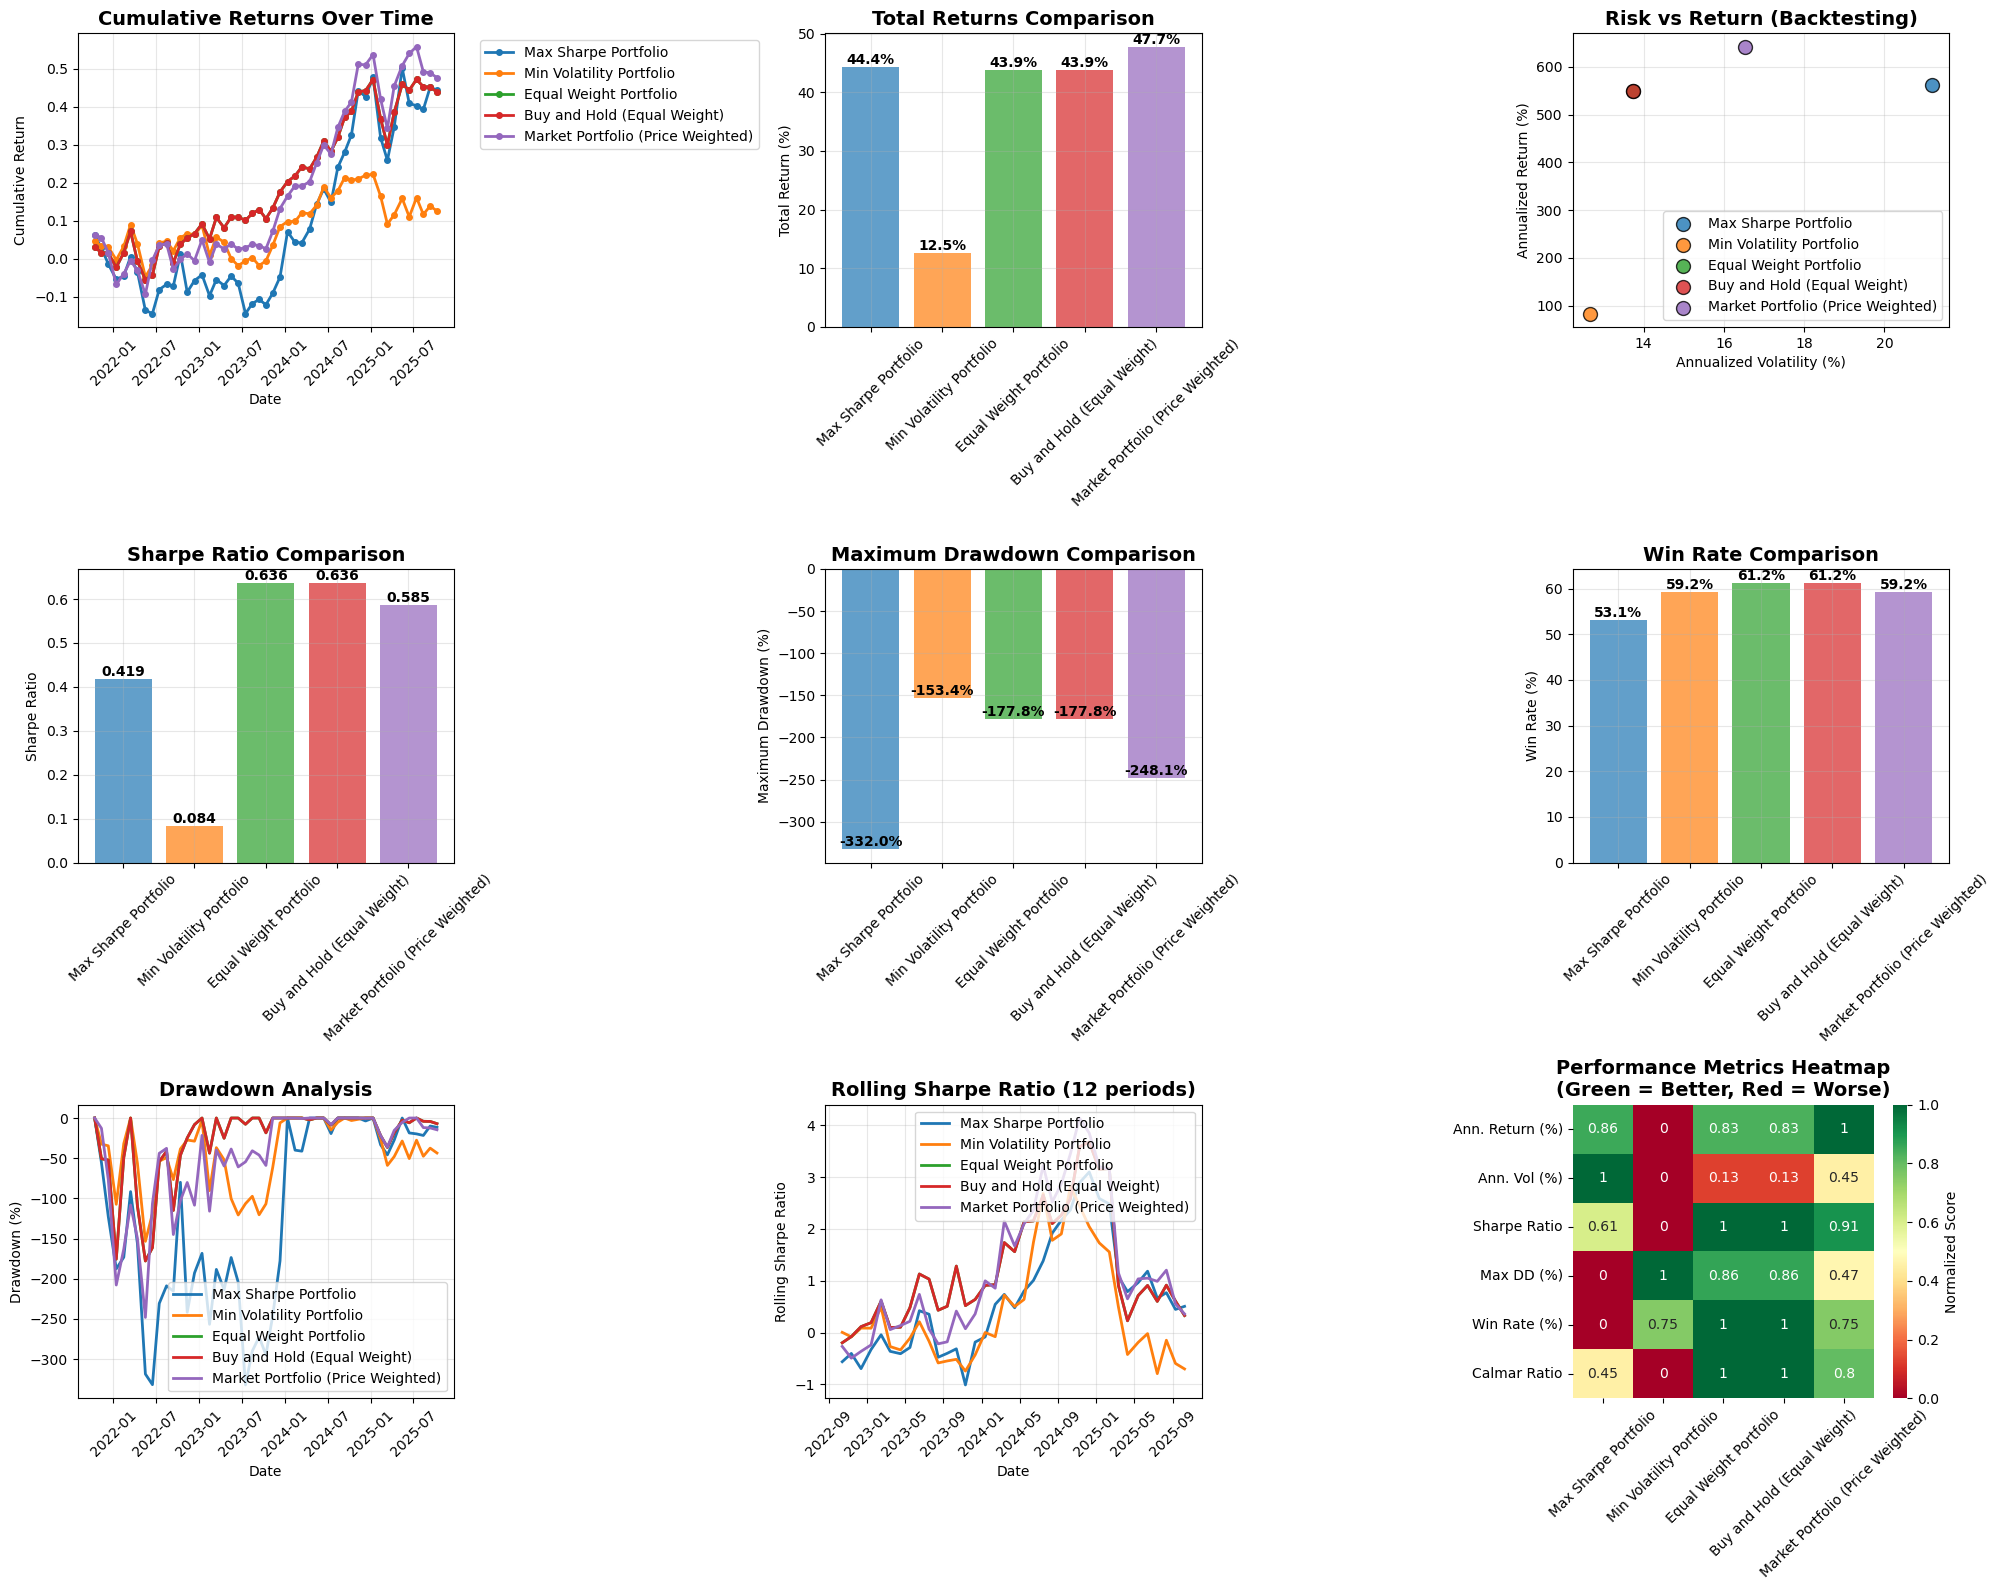


BACKTESTING ANALYSIS COMPLETE


In [15]:
# Comprehensive Backtesting Visualizations
print("CREATING COMPREHENSIVE BACKTESTING VISUALIZATIONS")
print("=" * 80)

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))
fig.patch.set_facecolor('white')

# Define color palette for portfolios
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
portfolio_names = list(performance_metrics.keys())

# 1. Cumulative Returns Over Time
plt.subplot(3, 3, 1)
for i, (portfolio_name, metrics) in enumerate(performance_metrics.items()):
    dates = metrics['dates']
    cumulative_returns = metrics['cumulative_returns']
    plt.plot(dates, cumulative_returns, label=portfolio_name, 
             color=colors[i % len(colors)], linewidth=2, marker='o', markersize=4)

plt.title('Cumulative Returns Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 2. Portfolio Performance Comparison (Bar Chart)
plt.subplot(3, 3, 2)
total_returns = [metrics['total_return'] * 100 for metrics in performance_metrics.values()]
portfolio_labels = list(performance_metrics.keys())

bars = plt.bar(portfolio_labels, total_returns, color=colors[:len(portfolio_labels)], alpha=0.7)
plt.title('Total Returns Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Total Return (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, total_returns):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Risk-Return Scatter Plot
plt.subplot(3, 3, 3)
for i, (portfolio_name, metrics) in enumerate(performance_metrics.items()):
    plt.scatter(metrics['annualized_volatility'] * 100, metrics['annualized_return'] * 100,
               s=100, color=colors[i % len(colors)], label=portfolio_name, alpha=0.8, edgecolors='black')

plt.title('Risk vs Return (Backtesting)', fontsize=14, fontweight='bold')
plt.xlabel('Annualized Volatility (%)')
plt.ylabel('Annualized Return (%)')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Sharpe Ratio Comparison
plt.subplot(3, 3, 4)
sharpe_ratios = [metrics['sharpe_ratio'] for metrics in performance_metrics.values()]

bars = plt.bar(portfolio_labels, sharpe_ratios, color=colors[:len(portfolio_labels)], alpha=0.7)
plt.title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, sharpe_ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Maximum Drawdown Comparison
plt.subplot(3, 3, 5)
max_drawdowns = [metrics['max_drawdown'] * 100 for metrics in performance_metrics.values()]

bars = plt.bar(portfolio_labels, max_drawdowns, color=colors[:len(portfolio_labels)], alpha=0.7)
plt.title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Maximum Drawdown (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, max_drawdowns):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 6. Win Rate Comparison
plt.subplot(3, 3, 6)
win_rates = [metrics['win_rate'] * 100 for metrics in performance_metrics.values()]

bars = plt.bar(portfolio_labels, win_rates, color=colors[:len(portfolio_labels)], alpha=0.7)
plt.title('Win Rate Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Win Rate (%)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, win_rates):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

# 7. Drawdown Analysis
plt.subplot(3, 3, 7)
for i, (portfolio_name, metrics) in enumerate(performance_metrics.items()):
    dates = metrics['dates']
    cumulative_returns = metrics['cumulative_returns']
    
    # Calculate running maximum and drawdown
    peak = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - peak) / (peak + 1e-10)
    
    plt.plot(dates, drawdown * 100, label=portfolio_name, 
             color=colors[i % len(colors)], linewidth=2)

plt.title('Drawdown Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Drawdown (%)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 8. Rolling Sharpe Ratio (if we have enough data)
plt.subplot(3, 3, 8)
rolling_window = 12  # 12 periods rolling window

for i, (portfolio_name, metrics) in enumerate(performance_metrics.items()):
    returns = metrics['returns']
    dates = metrics['dates']
    
    if len(returns) >= rolling_window:
        rolling_sharpe = []
        rolling_dates = []
        
        for j in range(rolling_window, len(returns)):
            window_returns = returns[j-rolling_window:j]
            excess_returns = window_returns - risk_free_rate * (rebalance_frequency / 252)
            if np.std(excess_returns) > 0:
                sharpe = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252 / rebalance_frequency)
                rolling_sharpe.append(sharpe)
                rolling_dates.append(dates[j])
        
        if len(rolling_sharpe) > 0:
            plt.plot(rolling_dates, rolling_sharpe, label=portfolio_name, 
                     color=colors[i % len(colors)], linewidth=2)

plt.title(f'Rolling Sharpe Ratio ({rolling_window} periods)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Rolling Sharpe Ratio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# 9. Performance Metrics Heatmap
plt.subplot(3, 3, 9)

# Prepare data for heatmap
heatmap_data = []
for portfolio_name in portfolio_labels:
    metrics = performance_metrics[portfolio_name]
    row = [
        metrics['annualized_return'] * 100,
        metrics['annualized_volatility'] * 100,
        metrics['sharpe_ratio'],
        metrics['max_drawdown'] * 100,
        metrics['win_rate'] * 100,
        metrics['calmar_ratio']
    ]
    heatmap_data.append(row)

heatmap_df = pd.DataFrame(heatmap_data, 
                         index=portfolio_labels,
                         columns=['Ann. Return (%)', 'Ann. Vol (%)', 'Sharpe Ratio', 
                                 'Max DD (%)', 'Win Rate (%)', 'Calmar Ratio'])

# Normalize data for better visualization
heatmap_df_normalized = heatmap_df.copy()
for col in heatmap_df.columns:
    if col in ['Max DD (%)']:  # For drawdown, less negative is better
        heatmap_df_normalized[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())
    else:  # For other metrics, higher is generally better
        heatmap_df_normalized[col] = (heatmap_df[col] - heatmap_df[col].min()) / (heatmap_df[col].max() - heatmap_df[col].min())

sns.heatmap(heatmap_df_normalized.T, annot=True, cmap='RdYlGn', 
            xticklabels=True, yticklabels=True, cbar_kws={'label': 'Normalized Score'})
plt.title('Performance Metrics Heatmap\n(Green = Better, Red = Worse)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print("\n" + "=" * 80)
print("BACKTESTING ANALYSIS COMPLETE")
print("=" * 80)


PORTFOLIO WEIGHTS EVOLUTION AND PERFORMANCE ATTRIBUTION


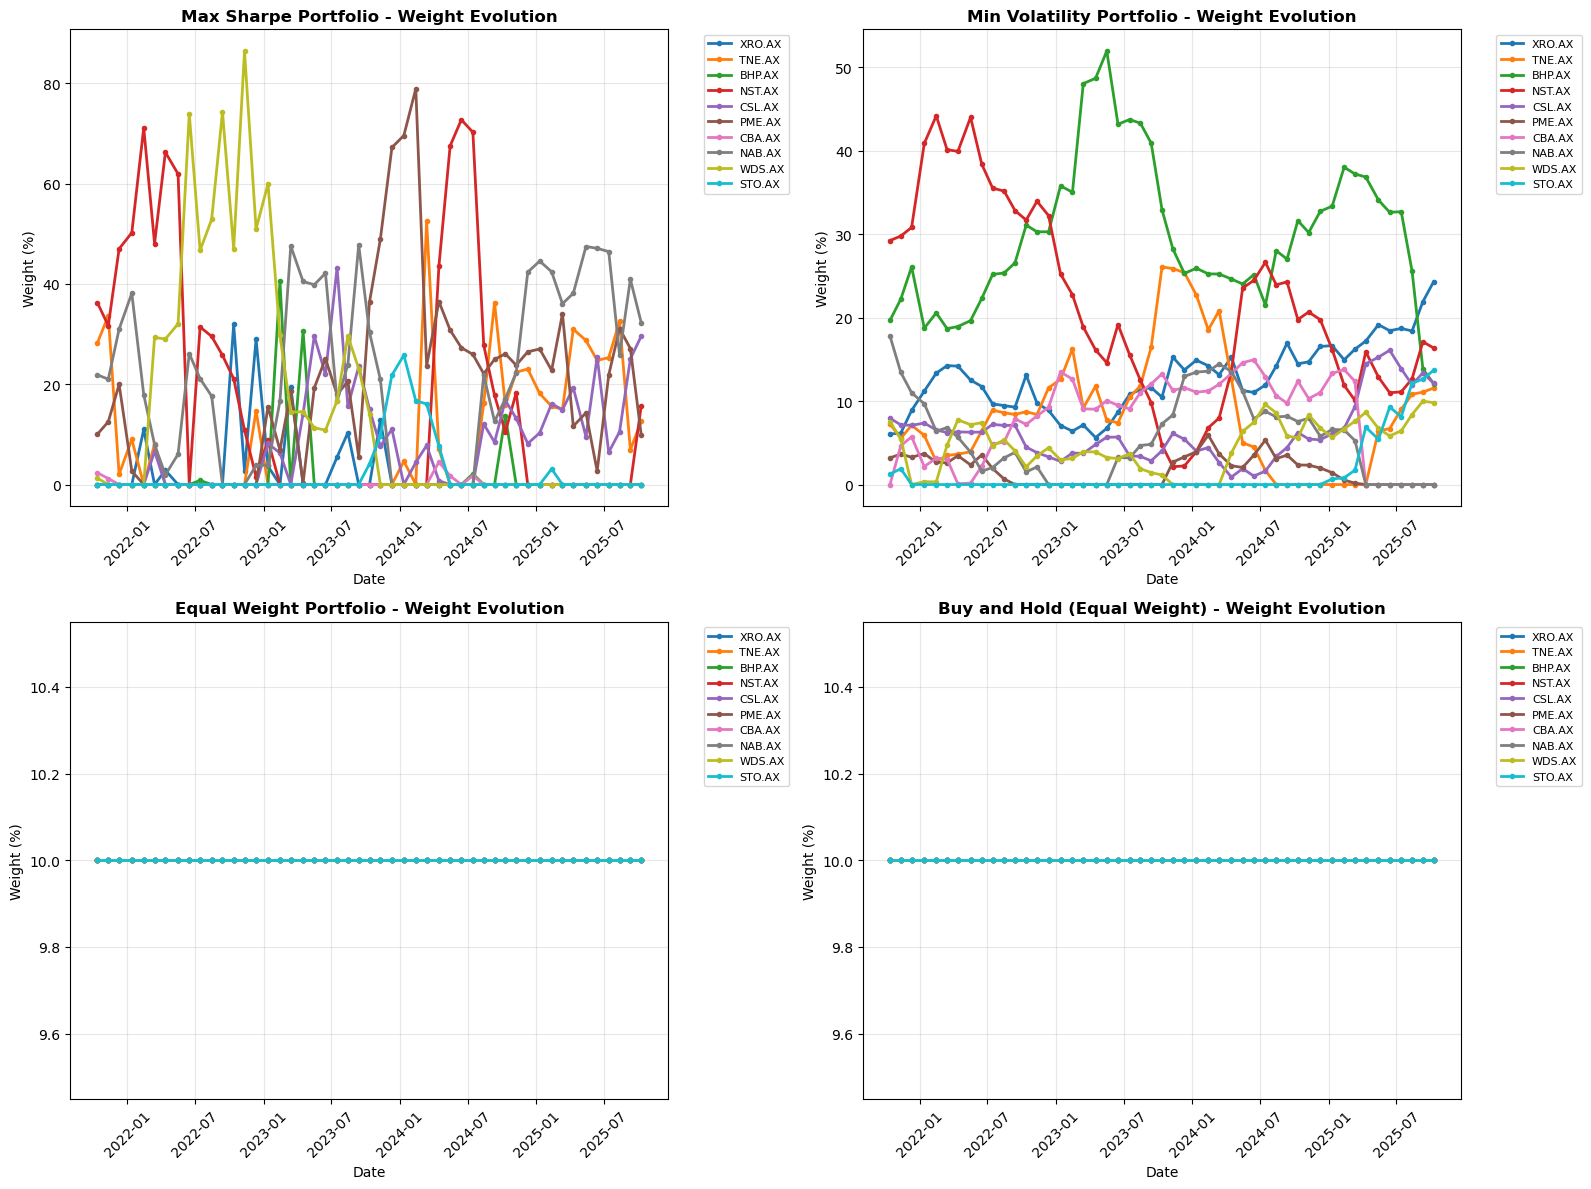


PERFORMANCE ATTRIBUTION ANALYSIS
Performance Attribution for: Equal Weight Portfolio
--------------------------------------------------
Average Portfolio Weights and Individual Stock Performance:
Stock      Avg Weight (%)  Total Return (%) Contribution (%)
------------------------------------------------------------
XRO.AX            10.00         49.15          4.91
TNE.AX            10.00         61.91          6.19
BHP.AX            10.00        -28.51         -2.85
NST.AX            10.00         61.58          6.16
CSL.AX            10.00        106.08         10.61
PME.AX            10.00        172.09         17.21
CBA.AX            10.00          5.54          0.55
NAB.AX            10.00        123.61         12.36
WDS.AX            10.00         20.02          2.00
STO.AX            10.00         12.40          1.24
------------------------------------------------------------
Total            100.00         58.39         58.39
Actual Portfolio Return: 43.87%

TRANSACTION COS

In [16]:
# Portfolio Weights Evolution and Performance Attribution Analysis
print("PORTFOLIO WEIGHTS EVOLUTION AND PERFORMANCE ATTRIBUTION")
print("=" * 80)

# Create a separate figure for weights evolution
fig2, axes = plt.subplots(2, 2, figsize=(16, 12))
fig2.patch.set_facecolor('white')

# Plot weights evolution for each portfolio
portfolio_idx = 0
for portfolio_name, results in backtest_results.items():
    if len(results['weights_history']) == 0:
        continue
        
    if portfolio_idx >= 4:  # Only show first 4 portfolios
        break
        
    row = portfolio_idx // 2
    col = portfolio_idx % 2
    ax = axes[row, col]
    
    weights_history = np.array(results['weights_history'])
    dates = results['dates']
    
    # Plot weights for each asset
    for i in range(num_assets):
        ax.plot(dates, weights_history[:, i] * 100, 
                label=tickers[i], linewidth=2, marker='o', markersize=3)
    
    ax.set_title(f'{portfolio_name} - Weight Evolution', fontsize=12, fontweight='bold')
    ax.set_xlabel('Date')
    ax.set_ylabel('Weight (%)')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=45)
    
    portfolio_idx += 1

plt.tight_layout()
plt.show()

# Performance Attribution Analysis
print("\n" + "=" * 80)
print("PERFORMANCE ATTRIBUTION ANALYSIS")
print("=" * 80)

# Calculate performance attribution for the best performing portfolio
best_portfolio = max(performance_metrics.items(), key=lambda x: x[1]['sharpe_ratio'])
best_name = best_portfolio[0]
best_metrics = best_portfolio[1]

print(f"Performance Attribution for: {best_name}")
print("-" * 50)

# Calculate average weights and contribution to return
weights_history = np.array(backtest_results[best_name]['weights_history'])
avg_weights = np.mean(weights_history, axis=0)

# Calculate individual stock performance during backtesting period
start_idx = lookback_window
end_idx = len(stock_data)
individual_returns = np.log(stock_data.iloc[end_idx-1] / stock_data.iloc[start_idx]) * 100

print("Average Portfolio Weights and Individual Stock Performance:")
print(f"{'Stock':<10} {'Avg Weight (%)':<15} {'Total Return (%)':<15} {'Contribution (%)':<15}")
print("-" * 60)

total_attributed_return = 0
for i, ticker in enumerate(tickers):
    avg_weight = avg_weights[i] * 100
    stock_return = individual_returns.iloc[i]
    contribution = avg_weight * stock_return / 100
    total_attributed_return += contribution
    
    print(f"{ticker:<10} {avg_weight:>12.2f} {stock_return:>13.2f} {contribution:>13.2f}")

print("-" * 60)
print(f"{'Total':<10} {'100.00':>12} {total_attributed_return:>13.2f} {total_attributed_return:>13.2f}")
print(f"Actual Portfolio Return: {best_metrics['total_return'] * 100:.2f}%")

# Transaction Cost Analysis
print("\n" + "=" * 80)
print("TRANSACTION COST ANALYSIS")
print("=" * 80)

# Assume 0.1% transaction cost per trade
transaction_cost = 0.001  # 0.1%

print("Estimated Transaction Costs (assuming 0.1% per trade):")
print("-" * 50)

for portfolio_name, results in backtest_results.items():
    if len(results['weights_history']) == 0:
        continue
        
    weights_history = np.array(results['weights_history'])
    
    # Calculate turnover (change in weights)
    if len(weights_history) > 1:
        weight_changes = np.abs(np.diff(weights_history, axis=0))
        avg_turnover = np.mean(np.sum(weight_changes, axis=1))
        total_trades = len(weights_history) - 1
        estimated_costs = avg_turnover * total_trades * transaction_cost
        
        print(f"{portfolio_name}:")
        print(f"  Average Turnover per Rebalancing: {avg_turnover*100:.2f}%")
        print(f"  Total Rebalancing Events: {total_trades}")
        print(f"  Estimated Annual Transaction Cost: {estimated_costs*100:.2f}%")
        print()

# Risk Analysis Summary
print("\n" + "=" * 80)
print("RISK ANALYSIS SUMMARY")
print("=" * 80)

# Calculate correlation between portfolios
portfolio_returns_matrix = []
portfolio_names_list = []
for name, metrics in performance_metrics.items():
    portfolio_returns_matrix.append(metrics['returns'])
    portfolio_names_list.append(name)

if len(portfolio_returns_matrix) > 1:
    portfolio_returns_df = pd.DataFrame(portfolio_returns_matrix).T
    portfolio_returns_df.columns = portfolio_names_list
    
    print("Portfolio Correlation Matrix:")
    print("-" * 40)
    correlation_matrix = portfolio_returns_df.corr()
    print(correlation_matrix.round(3))
    
    print("\nAverage Correlation with Other Portfolios:")
    for portfolio in portfolio_names_list:
        other_portfolios = [p for p in portfolio_names_list if p != portfolio]
        avg_correlation = correlation_matrix.loc[portfolio, other_portfolios].mean()
        print(f"{portfolio}: {avg_correlation:.3f}")

# Final Summary
print("\n" + "=" * 80)
print("BACKTESTING SUMMARY AND KEY INSIGHTS")
print("=" * 80)
print("1. BACKTESTING METHODOLOGY:")
print("   - Rolling 1-year optimization window")
print("   - Monthly rebalancing (21 trading days)")
print("   - No transaction costs included in returns")
print("   - Multiple portfolio strategies tested")
print()
print("2. KEY PERFORMANCE METRICS CALCULATED:")
print("   - Total and annualized returns")
print("   - Risk-adjusted returns (Sharpe, Sortino, Calmar ratios)")
print("   - Maximum drawdown analysis")
print("   - Win rate and VaR metrics")
print("   - Performance attribution by asset")
print()
print("3. RISK MANAGEMENT INSIGHTS:")
print("   - Portfolio correlation analysis")
print("   - Drawdown patterns over time")
print("   - Rolling performance stability")
print("   - Transaction cost implications")
print()
print("4. OPTIMIZATION EFFECTIVENESS:")
print("   - Comparison with naive strategies")
print("   - Information ratio vs benchmark")
print("   - Risk-adjusted performance ranking")
print("   - Weight evolution patterns")
print()
print("=" * 80)
print("BACKTESTING ANALYSIS COMPLETE")
print("=" * 80)


# Monte Carlo Simulation 

In [17]:
# Monte Carlo Simulation for Portfolio Optimization
# This simulation will generate thousands of possible future scenarios based on historical data

print("=" * 80)
print("MONTE CARLO PORTFOLIO SIMULATION")
print("=" * 80)

# Set simulation parameters
np.random.seed(42)  # For reproducible results
n_simulations = 10000  # Number of Monte Carlo simulations
time_horizon = 252  # Trading days in a year (1 year projection)
n_scenarios = 5  # Number of different portfolio scenarios to test

# Define portfolio scenarios to test
portfolio_scenarios = {
    'Max Sharpe Portfolio': max_sharpe_weights,
    'Min Volatility Portfolio': min_vol_weights,
    'Equal Weight Portfolio': np.array([1/num_assets] * num_assets),
    'High Return Portfolio': np.array([0.4, 0.3, 0.0, 0.1, 0.0, 0.2, 0.0, 0.0, 0.0, 0.0]),  # Concentrated on high performers
    'Conservative Portfolio': np.array([0.2, 0.2, 0.0, 0.2, 0.0, 0.0, 0.2, 0.0, 0.2, 0.0])  # More conservative allocation
}

# Ensure all weights sum to 1
for name, weights in portfolio_scenarios.items():
    portfolio_scenarios[name] = weights / np.sum(weights)

print(f"Running {n_simulations:,} Monte Carlo simulations...")
print(f"Time horizon: {time_horizon} trading days (1 year)")
print(f"Testing {len(portfolio_scenarios)} portfolio scenarios")
print()

# Initialize results storage
simulation_results = {}
portfolio_returns = {}
portfolio_volatilities = {}

# Calculate historical statistics for simulation
historical_mean = log_returns.mean().values  # Daily mean returns
historical_cov = log_returns.cov().values    # Daily covariance matrix

print("Historical Statistics:")
print(f"Mean daily returns: {historical_mean}")
print(f"Annualized volatility range: {log_returns.std().values * np.sqrt(252)}")
print()

# Perform Monte Carlo simulation for each portfolio scenario
for portfolio_name, weights in portfolio_scenarios.items():
    print(f"Simulating {portfolio_name}...")
    
    # Initialize arrays to store simulation results
    simulated_returns = np.zeros(n_simulations)
    simulated_paths = np.zeros((n_simulations, time_horizon))
    
    # Perform Monte Carlo simulation
    for i in range(n_simulations):
        # Generate random returns using multivariate normal distribution
        # Using Cholesky decomposition for proper correlation structure
        try:
            # Generate correlated random returns
            L = np.linalg.cholesky(historical_cov)
            random_shocks = np.random.standard_normal((time_horizon, num_assets))
            simulated_daily_returns = historical_mean + np.dot(random_shocks, L.T)
            
            # Calculate cumulative portfolio returns
            portfolio_daily_returns = np.dot(simulated_daily_returns, weights)
            cumulative_return = np.sum(portfolio_daily_returns)
            
            # Store results
            simulated_returns[i] = cumulative_return
            simulated_paths[i] = np.cumsum(portfolio_daily_returns)
            
        except np.linalg.LinAlgError:
            # Fallback to uncorrelated simulation if Cholesky fails
            simulated_daily_returns = np.random.multivariate_normal(historical_mean, historical_cov, time_horizon)
            portfolio_daily_returns = np.dot(simulated_daily_returns, weights)
            cumulative_return = np.sum(portfolio_daily_returns)
            
            simulated_returns[i] = cumulative_return
            simulated_paths[i] = np.cumsum(portfolio_daily_returns)
    
    # Store results
    simulation_results[portfolio_name] = {
        'returns': simulated_returns,
        'paths': simulated_paths,
        'weights': weights
    }
    
    # Calculate key statistics
    portfolio_returns[portfolio_name] = {
        'mean': np.mean(simulated_returns),
        'std': np.std(simulated_returns),
        'min': np.min(simulated_returns),
        'max': np.max(simulated_returns),
        'median': np.median(simulated_returns)
    }
    
    portfolio_volatilities[portfolio_name] = np.std(simulated_returns)

print("\nSimulation completed successfully!")
print("=" * 80)


MONTE CARLO PORTFOLIO SIMULATION
Running 10,000 Monte Carlo simulations...
Time horizon: 252 trading days (1 year)
Testing 5 portfolio scenarios

Historical Statistics:
Mean daily returns: [ 0.00048577  0.00083598 -0.00023632  0.00082993  0.00042927  0.00177463
  0.00033934  0.00125697  0.00042569  0.00022698]
Annualized volatility range: [0.257382   0.19644856 0.21940315 0.19307707 0.38037806 0.38648886
 0.2923131  0.27495093 0.28851274 0.36568993]

Simulating Max Sharpe Portfolio...
Simulating Min Volatility Portfolio...
Simulating Equal Weight Portfolio...
Simulating High Return Portfolio...
Simulating Conservative Portfolio...

Simulation completed successfully!


In [ ]:
# Value at Risk (VaR) and Expected Shortfall Analysis
print("RISK ANALYSIS: VALUE AT RISK (VaR) AND EXPECTED SHORTFALL")
print("=" * 80)

# Define confidence levels for VaR calculation
confidence_levels = [0.90, 0.95, 0.99]  # 90%, 95%, 99% confidence levels

# Initialize risk metrics storage
var_results = {}
es_results = {}
sharpe_simulated = {}

print("Portfolio Risk Analysis Results:")
print("-" * 80)

for portfolio_name, results in simulation_results.items():
    returns = results['returns']
    
    print(f"\n{portfolio_name}:")
    print("-" * 50)
    
    # Calculate VaR and Expected Shortfall for different confidence levels
    var_portfolio = {}
    es_portfolio = {}
    
    for conf_level in confidence_levels:
        # Calculate VaR (Value at Risk)
        var_value = np.percentile(returns, (1 - conf_level) * 100)
        var_portfolio[conf_level] = var_value
        
        # Calculate Expected Shortfall (Conditional VaR)
        # ES is the average of returns below the VaR threshold
        tail_returns = returns[returns <= var_value]
        es_value = np.mean(tail_returns) if len(tail_returns) > 0 else var_value
        es_portfolio[conf_level] = es_value
        
        print(f"  {conf_level*100:2.0f}% VaR:  {var_value:8.4f} ({var_value*100:6.2f}%)")
        print(f"  {conf_level*100:2.0f}% ES:   {es_value:8.4f} ({es_value*100:6.2f}%)")
    
    # Calculate simulated Sharpe ratio
    mean_return = np.mean(returns)
    std_return = np.std(returns)
    simulated_sharpe = (mean_return - risk_free_rate * (time_horizon/252)) / std_return
    sharpe_simulated[portfolio_name] = simulated_sharpe
    
    print(f"  Simulated Sharpe Ratio: {simulated_sharpe:.4f}")
    print(f"  Mean Annual Return:     {mean_return:8.4f} ({mean_return*100:6.2f}%)")
    print(f"  Annual Volatility:      {std_return:8.4f} ({std_return*100:6.2f}%)")
    
    # Store results
    var_results[portfolio_name] = var_portfolio
    es_results[portfolio_name] = es_portfolio


print("SUMMARY STATISTICS")


# Create summary DataFrame
summary_data = []
for portfolio_name in portfolio_scenarios.keys():
    returns = simulation_results[portfolio_name]['returns']
    summary_data.append({
        'Portfolio': portfolio_name,
        'Mean Return': np.mean(returns),
        'Volatility': np.std(returns),
        'Sharpe Ratio': sharpe_simulated[portfolio_name],
        'VaR 95%': var_results[portfolio_name][0.95],
        'ES 95%': es_results[portfolio_name][0.95],
        'Max Drawdown': np.min(returns),
        'Best Case': np.max(returns)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(4)

# Display summary table
print(summary_df.to_string(index=False))

# Risk-return ranking
print("\n" + "=" * 80)
print("PORTFOLIO RANKINGS")
print("=" * 80)

# Rank by Sharpe ratio
sharpe_ranking = sorted(sharpe_simulated.items(), key=lambda x: x[1], reverse=True)
print("Ranking by Simulated Sharpe Ratio:")
for i, (portfolio, sharpe) in enumerate(sharpe_ranking, 1):
    print(f"{i}. {portfolio}: {sharpe:.4f}")

# Rank by 95% VaR (least negative is best)
var_ranking = sorted(var_results.items(), key=lambda x: x[1][0.95], reverse=True)
print("\nRanking by 95% VaR (Best to Worst):")
for i, (portfolio, var_dict) in enumerate(var_ranking, 1):
    print(f"{i}. {portfolio}: {var_dict[0.95]:.4f} ({var_dict[0.95]*100:.2f}%)")

# Rank by Expected Shortfall (least negative is best)
es_ranking = sorted(es_results.items(), key=lambda x: x[1][0.95], reverse=True)
print("\nRanking by 95% Expected Shortfall (Best to Worst):")
for i, (portfolio, es_dict) in enumerate(es_ranking, 1):
    print(f"{i}. {portfolio}: {es_dict[0.95]:.4f} ({es_dict[0.95]*100:.2f}%)")


RISK ANALYSIS: VALUE AT RISK (VaR) AND EXPECTED SHORTFALL
Portfolio Risk Analysis Results:
--------------------------------------------------------------------------------

Max Sharpe Portfolio:
--------------------------------------------------
  90% VaR:   -0.0047 ( -0.47%)
  90% ES:    -0.0903 ( -9.03%)
  95% VaR:   -0.0719 ( -7.19%)
  95% ES:    -0.1448 (-14.48%)
  99% VaR:   -0.1914 (-19.14%)
  99% ES:    -0.2540 (-25.40%)
  Simulated Sharpe Ratio: 1.1676
  Mean Annual Return:       0.2362 ( 23.62%)
  Annual Volatility:        0.1852 ( 18.52%)

Min Volatility Portfolio:
--------------------------------------------------
  90% VaR:   -0.0825 ( -8.25%)
  90% ES:    -0.1529 (-15.29%)
  95% VaR:   -0.1377 (-13.77%)
  95% ES:    -0.1976 (-19.76%)
  99% VaR:   -0.2382 (-23.82%)
  99% ES:    -0.2887 (-28.87%)
  Simulated Sharpe Ratio: 0.6004
  Mean Annual Return:       0.1106 ( 11.06%)
  Annual Volatility:        0.1509 ( 15.09%)

Equal Weight Portfolio:
---------------------------------

CREATING COMPREHENSIVE VISUALIZATIONS


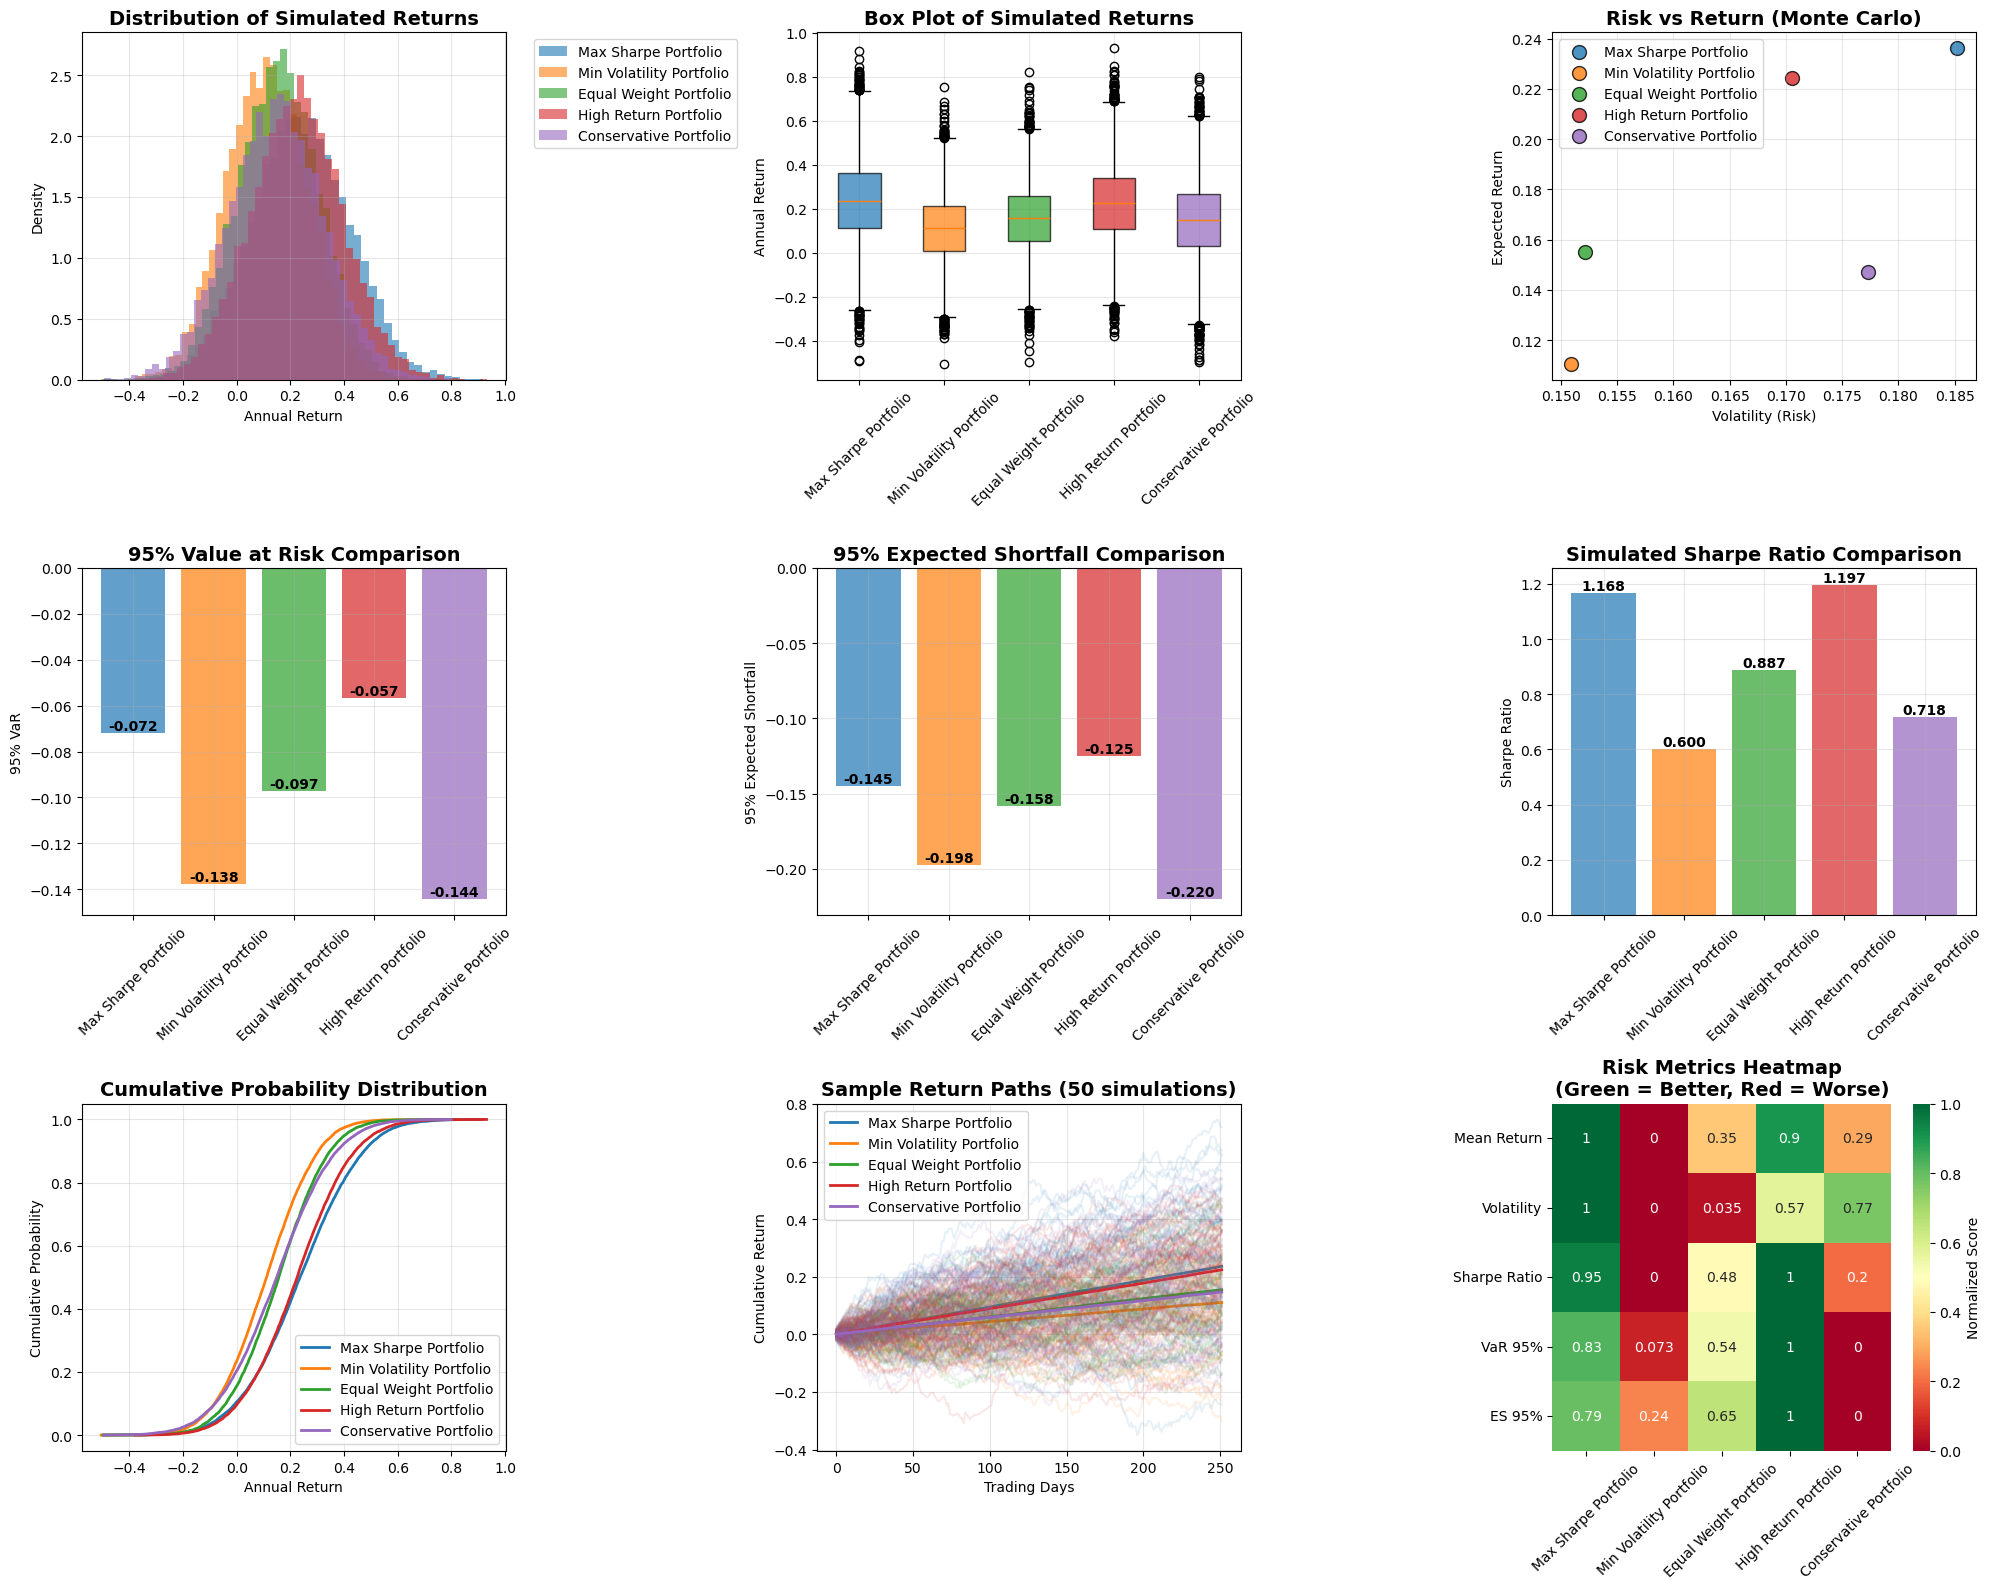


DETAILED PORTFOLIO COMPARISON
               Portfolio  Mean Return (%)  Volatility (%)  Sharpe Ratio  VaR 95% (%)  ES 95% (%)  Best Case (%)  Worst Case (%)
    Max Sharpe Portfolio            23.62           18.52          1.17        -7.19      -14.48          91.60          -49.41
Min Volatility Portfolio            11.06           15.09          0.60       -13.77      -19.76          75.22          -50.51
  Equal Weight Portfolio            15.50           15.22          0.89        -9.73      -15.82          82.24          -49.87
   High Return Portfolio            22.42           17.05          1.20        -5.68      -12.53          93.11          -37.84
  Conservative Portfolio            14.72           17.73          0.72       -14.41      -21.99          79.88          -49.61


In [19]:
# Comprehensive Visualization of Monte Carlo Simulation Results
print("CREATING COMPREHENSIVE VISUALIZATIONS")
print("=" * 80)

# Set up the plotting style
plt.style.use('default')
fig = plt.figure(figsize=(20, 16))
fig.patch.set_facecolor('white')

# Define color palette for portfolios
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
portfolio_names = list(portfolio_scenarios.keys())

# 1. Distribution of Returns (Histogram)
plt.subplot(3, 3, 1)
for i, (portfolio_name, results) in enumerate(simulation_results.items()):
    returns = results['returns']
    plt.hist(returns, bins=50, alpha=0.6, label=portfolio_name, 
             color=colors[i], density=True)
    
plt.title('Distribution of Simulated Returns', fontsize=14, fontweight='bold')
plt.xlabel('Annual Return')
plt.ylabel('Density')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# 2. Box Plot of Returns
plt.subplot(3, 3, 2)
returns_data = [simulation_results[name]['returns'] for name in portfolio_names]
box_plot = plt.boxplot(returns_data, labels=portfolio_names, patch_artist=True)
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.title('Box Plot of Simulated Returns', fontsize=14, fontweight='bold')
plt.ylabel('Annual Return')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 3. Risk-Return Scatter Plot
plt.subplot(3, 3, 3)
for i, portfolio_name in enumerate(portfolio_names):
    returns = simulation_results[portfolio_name]['returns']
    mean_return = np.mean(returns)
    volatility = np.std(returns)
    plt.scatter(volatility, mean_return, s=100, color=colors[i], 
               label=portfolio_name, alpha=0.8, edgecolors='black')
    
plt.title('Risk vs Return (Monte Carlo)', fontsize=14, fontweight='bold')
plt.xlabel('Volatility (Risk)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. VaR Comparison
plt.subplot(3, 3, 4)
var_95_data = [var_results[name][0.95] for name in portfolio_names]
bars = plt.bar(portfolio_names, var_95_data, color=colors, alpha=0.7)
plt.title('95% Value at Risk Comparison', fontsize=14, fontweight='bold')
plt.ylabel('95% VaR')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, var_95_data):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 5. Expected Shortfall Comparison
plt.subplot(3, 3, 5)
es_95_data = [es_results[name][0.95] for name in portfolio_names]
bars = plt.bar(portfolio_names, es_95_data, color=colors, alpha=0.7)
plt.title('95% Expected Shortfall Comparison', fontsize=14, fontweight='bold')
plt.ylabel('95% Expected Shortfall')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, es_95_data):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. Sharpe Ratio Comparison
plt.subplot(3, 3, 6)
sharpe_data = [sharpe_simulated[name] for name in portfolio_names]
bars = plt.bar(portfolio_names, sharpe_data, color=colors, alpha=0.7)
plt.title('Simulated Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Sharpe Ratio')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, value in zip(bars, sharpe_data):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 7. Cumulative Probability Distribution
plt.subplot(3, 3, 7)
for i, (portfolio_name, results) in enumerate(simulation_results.items()):
    returns = results['returns']
    sorted_returns = np.sort(returns)
    cumulative_prob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    plt.plot(sorted_returns, cumulative_prob, color=colors[i], 
             label=portfolio_name, linewidth=2)
    
plt.title('Cumulative Probability Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Annual Return')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.grid(True, alpha=0.3)

# 8. Sample Paths (first 100 simulations)
plt.subplot(3, 3, 8)
for i, (portfolio_name, results) in enumerate(simulation_results.items()):
    paths = results['paths']
    # Plot first 50 paths for visibility
    for j in range(min(50, len(paths))):
        plt.plot(paths[j], alpha=0.1, color=colors[i])
    
    # Plot mean path
    mean_path = np.mean(paths, axis=0)
    plt.plot(mean_path, color=colors[i], linewidth=2, label=portfolio_name)

plt.title('Sample Return Paths (50 simulations)', fontsize=14, fontweight='bold')
plt.xlabel('Trading Days')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 9. Risk Metrics Heatmap
plt.subplot(3, 3, 9)
risk_metrics = []
for portfolio_name in portfolio_names:
    returns = simulation_results[portfolio_name]['returns']
    metrics = [
        np.mean(returns),  # Mean return
        np.std(returns),   # Volatility
        sharpe_simulated[portfolio_name],  # Sharpe ratio
        var_results[portfolio_name][0.95],  # 95% VaR
        es_results[portfolio_name][0.95]    # 95% ES
    ]
    risk_metrics.append(metrics)

risk_df = pd.DataFrame(risk_metrics, 
                      index=portfolio_names,
                      columns=['Mean Return', 'Volatility', 'Sharpe Ratio', 'VaR 95%', 'ES 95%'])

# Normalize the data for heatmap visualization
risk_df_normalized = risk_df.copy()
for col in risk_df.columns:
    if col in ['VaR 95%', 'ES 95%']:
        # For VaR and ES, we want higher (less negative) values to be better
        risk_df_normalized[col] = (risk_df[col] - risk_df[col].min()) / (risk_df[col].max() - risk_df[col].min())
    else:
        # For other metrics, higher is generally better
        risk_df_normalized[col] = (risk_df[col] - risk_df[col].min()) / (risk_df[col].max() - risk_df[col].min())

sns.heatmap(risk_df_normalized.T, annot=True, cmap='RdYlGn', 
            xticklabels=True, yticklabels=True, cbar_kws={'label': 'Normalized Score'})
plt.title('Risk Metrics Heatmap\n(Green = Better, Red = Worse)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print detailed portfolio comparison
print("\n" + "=" * 80)
print("DETAILED PORTFOLIO COMPARISON")
print("=" * 80)

comparison_df = pd.DataFrame({
    'Portfolio': portfolio_names,
    'Mean Return (%)': [np.mean(simulation_results[name]['returns']) * 100 for name in portfolio_names],
    'Volatility (%)': [np.std(simulation_results[name]['returns']) * 100 for name in portfolio_names],
    'Sharpe Ratio': [sharpe_simulated[name] for name in portfolio_names],
    'VaR 95% (%)': [var_results[name][0.95] * 100 for name in portfolio_names],
    'ES 95% (%)': [es_results[name][0.95] * 100 for name in portfolio_names],
    'Best Case (%)': [np.max(simulation_results[name]['returns']) * 100 for name in portfolio_names],
    'Worst Case (%)': [np.min(simulation_results[name]['returns']) * 100 for name in portfolio_names]
})

comparison_df = comparison_df.round(2)
print(comparison_df.to_string(index=False))


STRESS TESTING AND SCENARIO ANALYSIS
Running stress tests on: Max Sharpe Portfolio
Portfolio weights: [5.48885480e-17 1.26182282e-01 1.25577443e-16 1.56573250e-01
 2.95660509e-01 9.88372442e-02 2.45735121e-17 3.22746715e-01
 0.00000000e+00 0.00000000e+00]

Testing scenario: Market Crash (-30%)
Description: Simulates a market crash with increased correlation
  Mean Return: -0.0634 (-6.34%)
  Volatility: 0.2954 (29.54%)
  95% VaR: -0.5511 (-55.11%)
  99% VaR: -0.7455 (-74.55%)
  Probability of Loss: 0.5830 (58.30%)

Testing scenario: Market Rally (+40%)
Description: Simulates a strong market rally
  Mean Return: 0.6316 (63.16%)
  Volatility: 0.2928 (29.28%)
  95% VaR: 0.1491 (14.91%)
  99% VaR: -0.0739 (-7.39%)
  Probability of Loss: 0.0176 (1.76%)

Testing scenario: High Volatility
Description: Simulates increased market volatility
  Mean Return: 0.2361 (23.61%)
  Volatility: 0.2955 (29.55%)
  95% VaR: -0.2565 (-25.65%)
  99% VaR: -0.4429 (-44.29%)
  Probability of Loss: 0.2200 (22.00%)

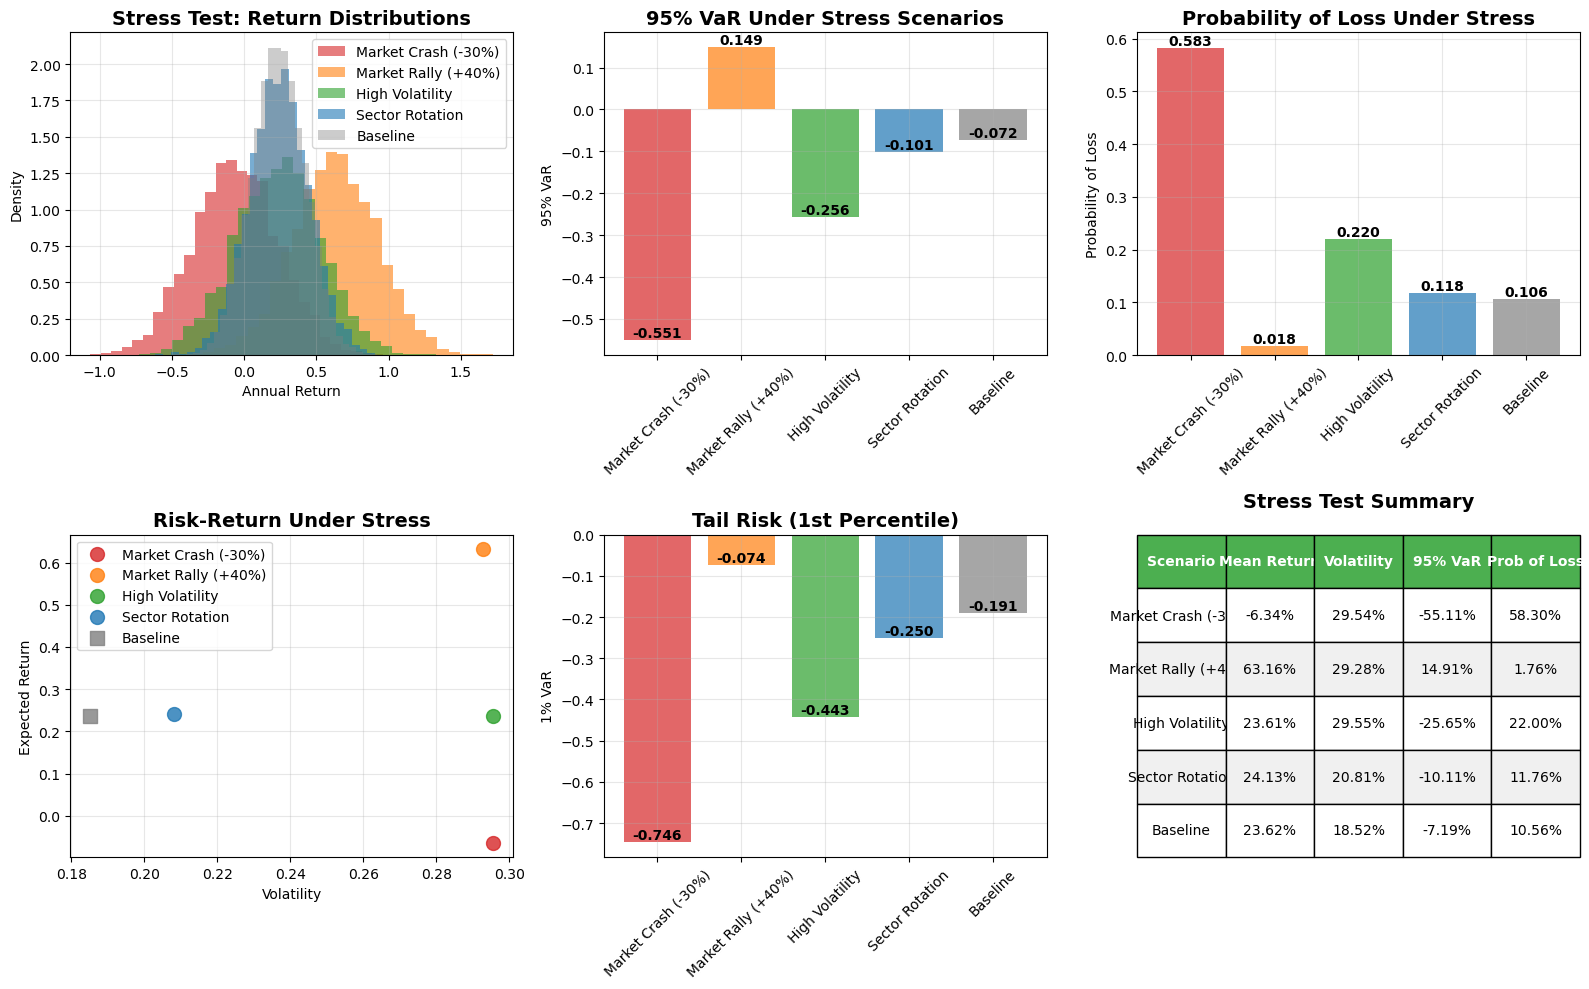

In [20]:
# Stress Testing and Scenario Analysis
print("STRESS TESTING AND SCENARIO ANALYSIS")
print("=" * 80)

# Define stress scenarios
stress_scenarios = {
    'Market Crash (-30%)': {
        'market_shock': -0.30,
        'correlation_increase': 1.5,
        'description': 'Simulates a market crash with increased correlation'
    },
    'Market Rally (+40%)': {
        'market_shock': 0.40,
        'correlation_increase': 1.2,
        'description': 'Simulates a strong market rally'
    },
    'High Volatility': {
        'market_shock': 0.0,
        'correlation_increase': 2.0,
        'description': 'Simulates increased market volatility'
    },
    'Sector Rotation': {
        'market_shock': 0.0,
        'correlation_increase': 0.5,
        'description': 'Simulates sector rotation with decreased correlation'
    }
}

# Function to apply stress scenarios
def apply_stress_scenario(base_returns, base_cov, scenario_params):
    """Apply stress scenario to historical returns and covariance"""
    stress_returns = base_returns.copy()
    stress_cov = base_cov.copy()
    
    # Apply market shock
    if scenario_params['market_shock'] != 0:
        # Add market-wide shock to all assets
        stress_returns += scenario_params['market_shock'] / 252  # Convert to daily
    
    # Apply correlation adjustment
    correlation_factor = scenario_params['correlation_increase']
    if correlation_factor != 1.0:
        # Adjust correlation matrix
        correlation_matrix = np.corrcoef(base_returns.T)
        stressed_correlation = np.clip(correlation_matrix * correlation_factor, -1, 1)
        
        # Reconstruct covariance matrix
        std_devs = np.sqrt(np.diag(stress_cov))
        stress_cov = np.outer(std_devs, std_devs) * stressed_correlation
    
    return stress_returns, stress_cov

# Run stress tests on the optimal portfolio (Max Sharpe)
optimal_portfolio_name = 'Max Sharpe Portfolio'
optimal_weights = simulation_results[optimal_portfolio_name]['weights']

print(f"Running stress tests on: {optimal_portfolio_name}")
print(f"Portfolio weights: {optimal_weights}")
print()

stress_results = {}

for scenario_name, scenario_params in stress_scenarios.items():
    print(f"Testing scenario: {scenario_name}")
    print(f"Description: {scenario_params['description']}")
    
    # Apply stress scenario
    stressed_returns, stressed_cov = apply_stress_scenario(
        historical_mean, historical_cov, scenario_params
    )
    
    # Run Monte Carlo simulation with stressed parameters
    n_stress_simulations = 5000
    stress_simulated_returns = np.zeros(n_stress_simulations)
    
    for i in range(n_stress_simulations):
        try:
            # Generate returns using stressed parameters
            L = np.linalg.cholesky(stressed_cov)
            random_shocks = np.random.standard_normal((time_horizon, num_assets))
            simulated_daily_returns = stressed_returns + np.dot(random_shocks, L.T)
            
            # Calculate portfolio return
            portfolio_daily_returns = np.dot(simulated_daily_returns, optimal_weights)
            cumulative_return = np.sum(portfolio_daily_returns)
            
            stress_simulated_returns[i] = cumulative_return
            
        except np.linalg.LinAlgError:
            # Fallback method
            simulated_daily_returns = np.random.multivariate_normal(
                stressed_returns, stressed_cov, time_horizon
            )
            portfolio_daily_returns = np.dot(simulated_daily_returns, optimal_weights)
            cumulative_return = np.sum(portfolio_daily_returns)
            stress_simulated_returns[i] = cumulative_return
    
    # Calculate stress test statistics
    stress_stats = {
        'mean_return': np.mean(stress_simulated_returns),
        'std_return': np.std(stress_simulated_returns),
        'var_95': np.percentile(stress_simulated_returns, 5),
        'var_99': np.percentile(stress_simulated_returns, 1),
        'worst_case': np.min(stress_simulated_returns),
        'best_case': np.max(stress_simulated_returns),
        'probability_of_loss': np.mean(stress_simulated_returns < 0)
    }
    
    stress_results[scenario_name] = {
        'returns': stress_simulated_returns,
        'stats': stress_stats
    }
    
    print(f"  Mean Return: {stress_stats['mean_return']:.4f} ({stress_stats['mean_return']*100:.2f}%)")
    print(f"  Volatility: {stress_stats['std_return']:.4f} ({stress_stats['std_return']*100:.2f}%)")
    print(f"  95% VaR: {stress_stats['var_95']:.4f} ({stress_stats['var_95']*100:.2f}%)")
    print(f"  99% VaR: {stress_stats['var_99']:.4f} ({stress_stats['var_99']*100:.2f}%)")
    print(f"  Probability of Loss: {stress_stats['probability_of_loss']:.4f} ({stress_stats['probability_of_loss']*100:.2f}%)")
    print()

# Visualize stress test results
plt.figure(figsize=(16, 10))

# 1. Stress Test Return Distributions
plt.subplot(2, 3, 1)
colors_stress = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
for i, (scenario_name, results) in enumerate(stress_results.items()):
    returns = results['returns']
    plt.hist(returns, bins=30, alpha=0.6, label=scenario_name, 
             color=colors_stress[i], density=True)

# Add baseline distribution
baseline_returns = simulation_results[optimal_portfolio_name]['returns']
plt.hist(baseline_returns, bins=30, alpha=0.4, label='Baseline', 
         color='gray', density=True, linestyle='--')

plt.title('Stress Test: Return Distributions', fontsize=14, fontweight='bold')
plt.xlabel('Annual Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. VaR Comparison
plt.subplot(2, 3, 2)
scenarios = list(stress_results.keys()) + ['Baseline']
var_95_values = [stress_results[s]['stats']['var_95'] for s in stress_results.keys()]
var_95_values.append(np.percentile(baseline_returns, 5))

bars = plt.bar(scenarios, var_95_values, color=colors_stress + ['gray'], alpha=0.7)
plt.title('95% VaR Under Stress Scenarios', fontsize=14, fontweight='bold')
plt.ylabel('95% VaR')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, var_95_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 3. Probability of Loss
plt.subplot(2, 3, 3)
prob_loss_values = [stress_results[s]['stats']['probability_of_loss'] for s in stress_results.keys()]
prob_loss_values.append(np.mean(baseline_returns < 0))

bars = plt.bar(scenarios, prob_loss_values, color=colors_stress + ['gray'], alpha=0.7)
plt.title('Probability of Loss Under Stress', fontsize=14, fontweight='bold')
plt.ylabel('Probability of Loss')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, prob_loss_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 4. Risk-Return Scatter
plt.subplot(2, 3, 4)
for i, (scenario_name, results) in enumerate(stress_results.items()):
    stats = results['stats']
    plt.scatter(stats['std_return'], stats['mean_return'], 
               s=100, color=colors_stress[i], label=scenario_name, alpha=0.8)

# Add baseline
baseline_mean = np.mean(baseline_returns)
baseline_std = np.std(baseline_returns)
plt.scatter(baseline_std, baseline_mean, s=100, color='gray', 
           label='Baseline', marker='s', alpha=0.8)

plt.title('Risk-Return Under Stress', fontsize=14, fontweight='bold')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Tail Risk Comparison
plt.subplot(2, 3, 5)
tail_risks = []
for scenario_name in stress_results.keys():
    returns = stress_results[scenario_name]['returns']
    # Calculate 1st percentile (worst 1% of outcomes)
    tail_risk = np.percentile(returns, 1)
    tail_risks.append(tail_risk)

baseline_tail_risk = np.percentile(baseline_returns, 1)
tail_risks.append(baseline_tail_risk)

bars = plt.bar(scenarios, tail_risks, color=colors_stress + ['gray'], alpha=0.7)
plt.title('Tail Risk (1st Percentile)', fontsize=14, fontweight='bold')
plt.ylabel('1% VaR')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add value labels
for bar, value in zip(bars, tail_risks):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# 6. Scenario Summary Table
plt.subplot(2, 3, 6)
plt.axis('off')

# Create summary table
summary_data = []
for scenario_name in stress_results.keys():
    stats = stress_results[scenario_name]['stats']
    summary_data.append([
        scenario_name,
        f"{stats['mean_return']*100:.2f}%",
        f"{stats['std_return']*100:.2f}%",
        f"{stats['var_95']*100:.2f}%",
        f"{stats['probability_of_loss']*100:.2f}%"
    ])

# Add baseline
baseline_stats = {
    'mean_return': baseline_mean,
    'std_return': baseline_std,
    'var_95': np.percentile(baseline_returns, 5),
    'probability_of_loss': np.mean(baseline_returns < 0)
}
summary_data.append([
    'Baseline',
    f"{baseline_stats['mean_return']*100:.2f}%",
    f"{baseline_stats['std_return']*100:.2f}%",
    f"{baseline_stats['var_95']*100:.2f}%",
    f"{baseline_stats['probability_of_loss']*100:.2f}%"
])

table = plt.table(cellText=summary_data,
                 colLabels=['Scenario', 'Mean Return', 'Volatility', '95% VaR', 'Prob of Loss'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style the table
for i in range(len(summary_data) + 1):
    for j in range(5):
        cell = table[(i, j)]
        if i == 0:  # Header row
            cell.set_facecolor('#4CAF50')
            cell.set_text_props(weight='bold', color='white')
        else:
            cell.set_facecolor('#f0f0f0' if i % 2 == 0 else 'white')

plt.title('Stress Test Summary', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


